# cross validation

In [1]:
# ==== Environment Setup ====
import os
import shutil
import warnings
import time

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ==== Core Python ====
import copy
import json
import pickle

# ==== Data Handling ====
import numpy as np
import pandas as pd

# ==== Visualization ====
import matplotlib.pyplot as plt
import seaborn as sns

# ==== PyTorch ====
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

# ==== HuggingFace Transformers ====
from transformers import AutoModel, AutoTokenizer
from transformers import BertModel, BertTokenizerFast

# ==== Scikit-learn ====
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)


In [2]:
# Load datasets
train = pd.read_csv('/content/train.csv')
elderly_with_label = pd.read_csv('/content/elderly.csv')
young_with_label = pd.read_csv('/content/young.csv')

In [3]:
# Check and remove duplicates in train
train_duplicates = train.duplicated().sum()
if train_duplicates > 0:
    print(f"Found {train_duplicates} duplicate rows in train.csv.")
    train = train.drop_duplicates()
else:
    print("No duplicate rows found in train.csv.")

# Check and remove duplicates in test
test_duplicates = elderly_with_label.duplicated().sum()
if test_duplicates > 0:
    print(f"Found {test_duplicates} duplicate rows in elderly-test.csv.")
    elderly_with_label = elderly_with_label.drop_duplicates()
else:
    print("No duplicate rows found in elderly-test.csv.")

test_duplicates = young_with_label.duplicated().sum()
if test_duplicates > 0:
    print(f"Found {test_duplicates} duplicate rows in young-test.csv.")
    young_with_label = young_with_label.drop_duplicates()
else:
    print("No duplicate rows found in young-test.csv.")

Found 3884 duplicate rows in train.csv.
Found 25 duplicate rows in elderly-test.csv.
Found 107 duplicate rows in young-test.csv.


In [4]:
# Create a new DataFrame without the 'label' column
elderly_without_label = elderly_with_label.drop(columns=['label'])
young_without_label = young_with_label.drop(columns=['label'])

data = train

In [5]:
# Load and normalize text columns
train_texts = train["transcript_hebrew"].astype(str)
elderly_texts = elderly_without_label["transcript_hebrew"].astype(str)
young_texts = young_without_label["transcript_hebrew"].astype(str)

# Find duplicates
duplicates_with_elderly = train_texts[train_texts.isin(elderly_texts)].drop_duplicates()
duplicates_with_young = train_texts[train_texts.isin(young_texts)].drop_duplicates()

# Print duplicate lines
print("Duplicate lines found between train and elderly:")
print(duplicates_with_elderly.to_string(index=False))

print("\nDuplicate lines found between train and young:")
print(duplicates_with_young.to_string(index=False))

# Remove duplicates from train
train = train[~train["transcript_hebrew"].isin(duplicates_with_elderly)]
train = train[~train["transcript_hebrew"].isin(duplicates_with_young)]

print(f"\n Final train size after removing duplicates: {len(train)} rows")


Duplicate lines found between train and elderly:
Series([], )

Duplicate lines found between train and young:
 האם אמור לרדת מחר גשם בתל אביב

 Final train size after removing duplicates: 2513 rows


In [6]:
# Encode labels
le = LabelEncoder()
data['intent_num'] = le.fit_transform(data['intent'])
map_intent = dict(zip(le.transform(le.classes_), le.classes_))

map_intent

{np.int64(0): 'alarm_set',
 np.int64(1): 'calendar_set',
 np.int64(2): 'call_contact',
 np.int64(3): 'camera_query',
 np.int64(4): 'iot_wemo_on',
 np.int64(5): 'lists_createoradd',
 np.int64(6): 'query',
 np.int64(7): 'send_message',
 np.int64(8): 'transport_query',
 np.int64(9): 'weather_query'}

In [7]:
X = data['transcript_hebrew'].values
y = data['intent_num'].values
X, y = shuffle(X, y, random_state=42)

In [8]:
# Load tokenizer and model
model_name = 'avichr/heBERT'
tokenizer = BertTokenizerFast.from_pretrained(model_name)
base_model = BertModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/299k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at avichr/heBERT and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# MODEL SAVING AND LOADING FUNCTIONS
def save_complete_model(model, tokenizer, map_intent, model_dir="complete_model"):
    """Save everything needed to reload the model in another notebook."""
    os.makedirs(model_dir, exist_ok=True)

    # 1. Save model weights
    torch.save(model.state_dict(), os.path.join(model_dir, "model_weights.pt"))

    # 2. Save tokenizer
    tokenizer.save_pretrained(os.path.join(model_dir, "tokenizer"))

    # 3. Save intent mapping (convert keys to strings for JSON)
    cleaned_map_intent = {str(k): v for k, v in map_intent.items()}
    with open(os.path.join(model_dir, "intent_mapping.json"), "w") as f:
        json.dump(cleaned_map_intent, f)

    # 4. Save model config info
    config_info = {
        "num_classes": len(map_intent),
        "base_model_name": tokenizer.name_or_path if hasattr(tokenizer, 'name_or_path') else "unknown",
        "hidden_size": model.bert.config.hidden_size
    }
    with open(os.path.join(model_dir, "model_config.json"), "w") as f:
        json.dump(config_info, f)

    print(f"✅ Complete model saved to: {model_dir}")
    return model_dir

In [10]:
# MODEL DEFINITION
class BertForIntentClassification(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BertForIntentClassification, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits


In [24]:
# PLOTTING FUNCTIONS
def plot_training_stats(train_losses, val_losses, train_accuracies, val_accuracies, lr, bs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_title(f'Loss Curves (LR={lr}, BS={bs})')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(train_accuracies, label='Train Acc', marker='o')
    ax2.plot(val_accuracies, label='Val Acc', marker='s')
    ax2.set_title(f'Accuracy Curves (LR={lr}, BS={bs})')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()



def plot_grouped_val_loss(val_loss_summary, learning_rates, batch_sizes):
    n_lr = len(learning_rates)
    x   = np.arange(n_lr)
    width = 0.2

    fig, ax = plt.subplots(figsize=(10,6))
    for i, bs in enumerate(batch_sizes):
        losses = val_loss_summary.get(bs, [None]*n_lr)
        ax.bar(x + i*width, losses, width, label=f"Batch Size {bs}")

    # center the x-ticks under the group
    ax.set_xticks(x + width*(len(batch_sizes)-1)/2)
    ax.set_xticklabels([f"{lr:.0e}" for lr in learning_rates])

    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Validation Loss")
    ax.set_title("Validation Loss Comparison")
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [12]:
def load_complete_model(model_dir="complete_model"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # 1. Load model config
    with open(os.path.join(model_dir, "model_config.json"), "r") as f:
        config = json.load(f)
    # 2. Load intent mapping
    with open(os.path.join(model_dir, "intent_mapping.json"), "r") as f:
        map_intent = json.load(f)
    # 3. Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(os.path.join(model_dir, "tokenizer"))
    # 4. Load base BERT model by original name to match checkpoint vocab
    base_model = AutoModel.from_pretrained(config.get("base_model_name", "avichr/heBERT"))
    # 5. Create classification model and load weights
    model = BertForIntentClassification(base_model, config["num_classes"])
    model.load_state_dict(torch.load(os.path.join(model_dir, "model_weights.pt"), map_location=device), strict=True)
    model.to(device).eval()
    print(f"✅ Model loaded successfully from: {model_dir}")
    print(f"📊 Number of classes: {config['num_classes']}")
    print(f"🏷️ Intent labels: {list(map_intent.values())}")
    return model, tokenizer, map_intent

In [27]:
def run_grid_search(
    encoded_inputs, labels,
    encoded_inputs_test, labels_test,
    map_intent, base_bert_model, tokenizer,
    model_save_dir="best_model"
):
    best_val_loss = float('inf')
    best_bs = None
    best_lr = None
    best_report = None
    best_cm = None
    best_preds, best_labels = [], []
    best_model = None

    learning_rates = [5e-5, 2e-5, 1e-5]
    batch_sizes    = [16, 32,64]
    num_classes    = len(map_intent)
    device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    val_loss_summary = {bs: [] for bs in batch_sizes}

    for lr in learning_rates:
        for bs in batch_sizes:
            print(f"\nTraining with LR={lr}, BS={bs} on {device}")
            model     = BertForIntentClassification(copy.deepcopy(base_bert_model), num_classes).to(device)
            optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
            criterion = nn.CrossEntropyLoss()

            train_dataset = TensorDataset(
                encoded_inputs['input_ids'],
                encoded_inputs['attention_mask'],
                torch.tensor(labels)
            )
            val_dataset = TensorDataset(
                encoded_inputs_test['input_ids'],
                encoded_inputs_test['attention_mask'],
                torch.tensor(labels_test)
            )
            train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
            val_loader   = DataLoader(val_dataset,   batch_size=bs)

            best_loss          = float('inf')
            early_stop_counter = 0
            patience           = 1       # stop after 1 non-improving epoch
            min_improvement    = 0.0     # any drop counts as improvement

            train_losses, val_losses         = [], []
            train_accuracies, val_accuracies = [], []

            for epoch in range(5):
                # — training —
                model.train()
                total_train_loss = correct_train = total_train = 0
                for input_ids, attention_mask, y in train_loader:
                    input_ids, attention_mask, y = input_ids.to(device), attention_mask.to(device), y.to(device)
                    optimizer.zero_grad()
                    outputs = model(input_ids, attention_mask)
                    loss    = criterion(outputs, y)
                    loss.backward()
                    optimizer.step()

                    total_train_loss += loss.item()
                    preds = torch.argmax(outputs, dim=1)
                    correct_train += (preds == y).sum().item()
                    total_train   += y.size(0)

                avg_train_loss = total_train_loss / len(train_loader)
                train_accuracy = correct_train / total_train

                # — validation —
                model.eval()
                val_loss = correct_val = total_val = 0
                all_preds, all_labels = [], []
                with torch.no_grad():
                    for input_ids, attention_mask, y in val_loader:
                        input_ids, attention_mask, y = input_ids.to(device), attention_mask.to(device), y.to(device)
                        outputs = model(input_ids, attention_mask)
                        loss    = criterion(outputs, y)
                        val_loss       += loss.item()
                        preds           = torch.argmax(outputs, dim=1)
                        correct_val    += (preds == y).sum().item()
                        total_val      += y.size(0)
                        all_preds.extend(preds.cpu().numpy())
                        all_labels.extend(y.cpu().numpy())

                avg_val_loss  = val_loss / len(val_loader)
                val_accuracy  = correct_val / total_val

                train_losses.append(avg_train_loss)
                val_losses.append(avg_val_loss)
                train_accuracies.append(train_accuracy)
                val_accuracies.append(val_accuracy)

                print(f"Epoch {epoch+1}: "
                      f"Train Loss={avg_train_loss:.4f}, Train Acc={train_accuracy:.4f}, "
                      f"Val Loss={avg_val_loss:.4f}, Val Acc={val_accuracy:.4f}")

                # — early stopping + track best —
                if avg_val_loss < best_loss - min_improvement:
                    best_loss = avg_val_loss
                    early_stop_counter = 0

                    if avg_val_loss < best_val_loss:
                        best_val_loss = avg_val_loss
                        best_model    = copy.deepcopy(model)
                        best_bs, best_lr = bs, lr
                        best_preds, best_labels = all_preds, all_labels

                        best_used_names = [
                            map_intent[i] for i in sorted(set(best_labels + best_preds))
                        ]
                        best_cm     = confusion_matrix(best_labels, best_preds)
                        best_report = classification_report(
                            best_labels, best_preds,
                            target_names=best_used_names,
                            digits=2
                        )
                else:
                    early_stop_counter += 1
                    if early_stop_counter >= patience:
                        print(f"⏹ Early stopping at epoch {epoch+1}")
                        break

            # plot stats for this config
            plot_training_stats(train_losses, val_losses,
                                train_accuracies, val_accuracies,
                                lr, bs)
            val_loss_summary[bs].append(best_loss)

            # cleanup GPU memory
            del model
            torch.cuda.empty_cache()

    # — after grid search, save best model —
    if best_model is not None:
        save_complete_model(best_model, tokenizer, map_intent, model_save_dir)
        try:
            shutil.make_archive(model_save_dir, 'zip', model_save_dir)
        except Exception:
            pass

    # — final confusion matrix & summary plot —
    if best_cm is not None:
        plt.figure(figsize=(10, 8))
        sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=best_used_names,
                    yticklabels=best_used_names)
        plt.title("Best Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    plot_grouped_val_loss(
    val_loss_summary,
    learning_rates=learning_rates,
    batch_sizes=batch_sizes)


    print(f"\n✅ Best Model Saved to: {model_save_dir}")
    print("Classification Report:\n", best_report)

    return model_save_dir, best_bs, best_lr


In [15]:
# PREDICTION FUNCTION
def predict_intent(text, model, tokenizer, map_intent, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    encoded = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
    with torch.no_grad():
        outputs = model(encoded['input_ids'], encoded['attention_mask'])
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predicted_class = torch.argmax(outputs, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    return {
        'text': text,
        'predicted_intent': map_intent[predicted_class],
        'confidence': confidence,
        'predicted_class': predicted_class
    }



========== Fold 1 ========== 

Training with LR=5e-05, BS=16 on cuda
Epoch 1: Train Loss=0.3232, Train Acc=0.9050, Val Loss=0.0498, Val Acc=0.9801
Epoch 2: Train Loss=0.0257, Train Acc=0.9915, Val Loss=0.0678, Val Acc=0.9781
⏹ Early stopping at epoch 2


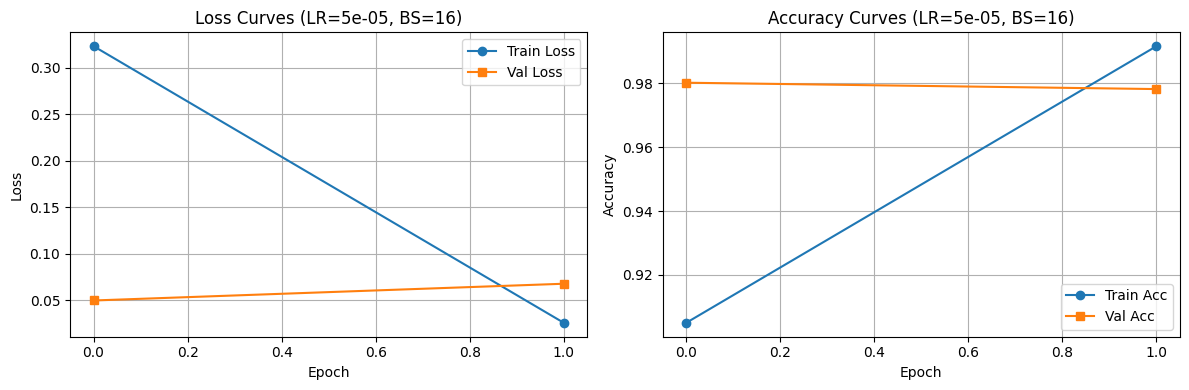


Training with LR=5e-05, BS=32 on cuda
Epoch 1: Train Loss=0.4801, Train Acc=0.8598, Val Loss=0.0469, Val Acc=0.9841
Epoch 2: Train Loss=0.0159, Train Acc=0.9965, Val Loss=0.0447, Val Acc=0.9801
Epoch 3: Train Loss=0.0057, Train Acc=0.9985, Val Loss=0.0411, Val Acc=0.9881
Epoch 4: Train Loss=0.0019, Train Acc=1.0000, Val Loss=0.0376, Val Acc=0.9901
Epoch 5: Train Loss=0.0010, Train Acc=1.0000, Val Loss=0.0381, Val Acc=0.9901
⏹ Early stopping at epoch 5


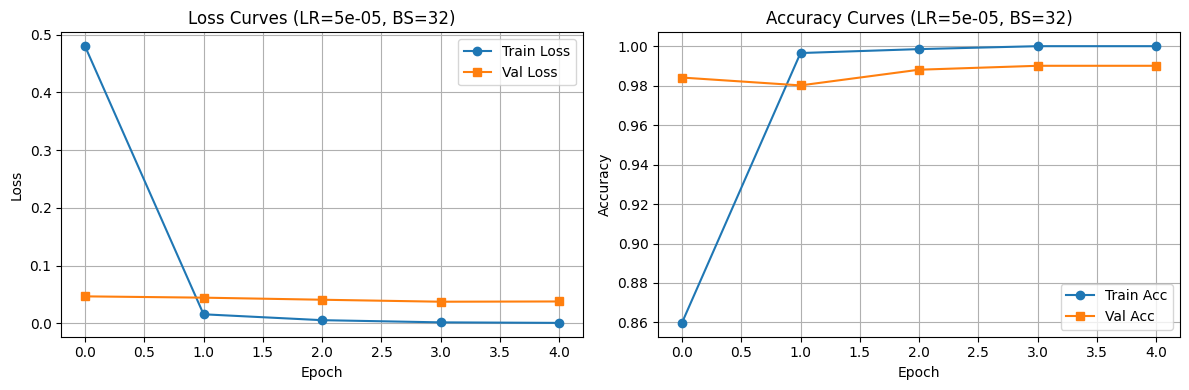


Training with LR=5e-05, BS=64 on cuda
Epoch 1: Train Loss=0.7376, Train Acc=0.7777, Val Loss=0.0988, Val Acc=0.9761
Epoch 2: Train Loss=0.0273, Train Acc=0.9945, Val Loss=0.0701, Val Acc=0.9861
Epoch 3: Train Loss=0.0217, Train Acc=0.9930, Val Loss=0.0595, Val Acc=0.9881
Epoch 4: Train Loss=0.0054, Train Acc=0.9990, Val Loss=0.0557, Val Acc=0.9861
Epoch 5: Train Loss=0.0038, Train Acc=0.9995, Val Loss=0.0576, Val Acc=0.9841
⏹ Early stopping at epoch 5


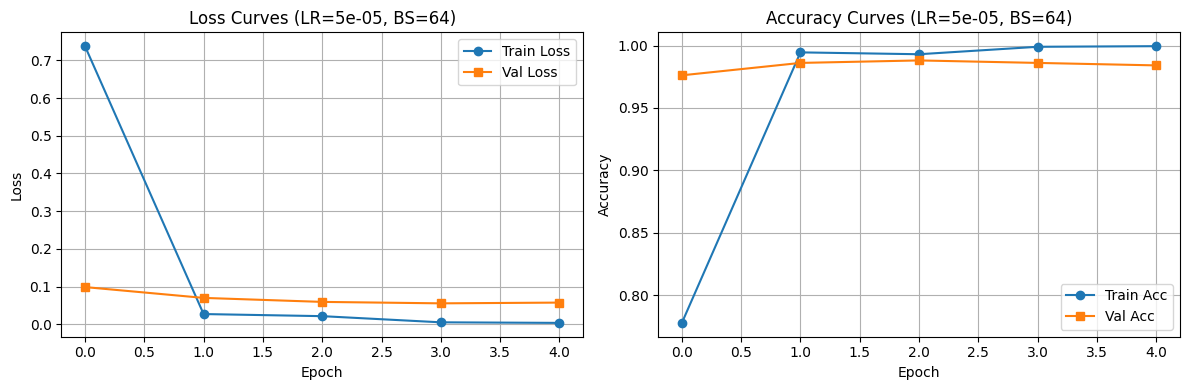


Training with LR=2e-05, BS=16 on cuda
Epoch 1: Train Loss=0.6248, Train Acc=0.8274, Val Loss=0.0877, Val Acc=0.9722
Epoch 2: Train Loss=0.0376, Train Acc=0.9940, Val Loss=0.0408, Val Acc=0.9861
Epoch 3: Train Loss=0.0077, Train Acc=1.0000, Val Loss=0.0426, Val Acc=0.9881
⏹ Early stopping at epoch 3


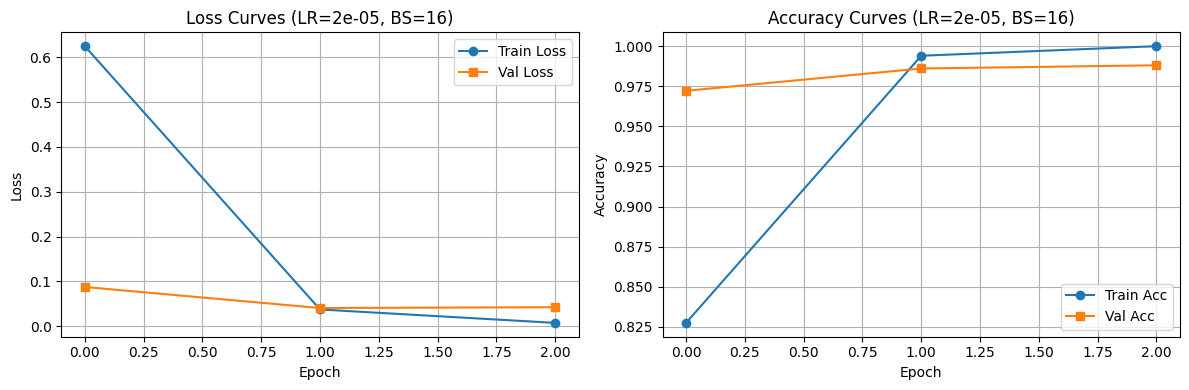


Training with LR=2e-05, BS=32 on cuda
Epoch 1: Train Loss=0.8667, Train Acc=0.7514, Val Loss=0.1039, Val Acc=0.9742
Epoch 2: Train Loss=0.0552, Train Acc=0.9925, Val Loss=0.0577, Val Acc=0.9841
Epoch 3: Train Loss=0.0148, Train Acc=0.9995, Val Loss=0.0574, Val Acc=0.9861
Epoch 4: Train Loss=0.0073, Train Acc=0.9995, Val Loss=0.0531, Val Acc=0.9861
Epoch 5: Train Loss=0.0044, Train Acc=1.0000, Val Loss=0.0444, Val Acc=0.9881


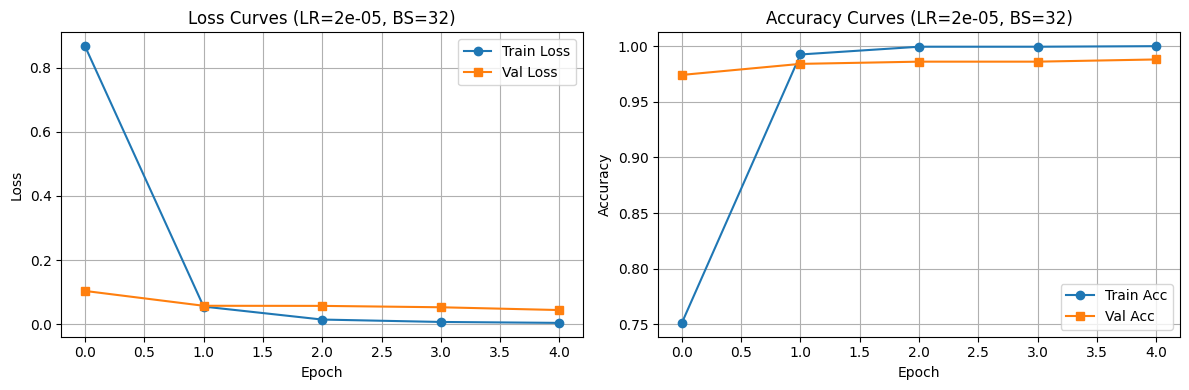


Training with LR=2e-05, BS=64 on cuda
Epoch 1: Train Loss=1.2474, Train Acc=0.6330, Val Loss=0.2462, Val Acc=0.9682
Epoch 2: Train Loss=0.1487, Train Acc=0.9781, Val Loss=0.0765, Val Acc=0.9801
Epoch 3: Train Loss=0.0320, Train Acc=0.9960, Val Loss=0.0654, Val Acc=0.9801
Epoch 4: Train Loss=0.0152, Train Acc=1.0000, Val Loss=0.0534, Val Acc=0.9821
Epoch 5: Train Loss=0.0086, Train Acc=1.0000, Val Loss=0.0551, Val Acc=0.9861
⏹ Early stopping at epoch 5


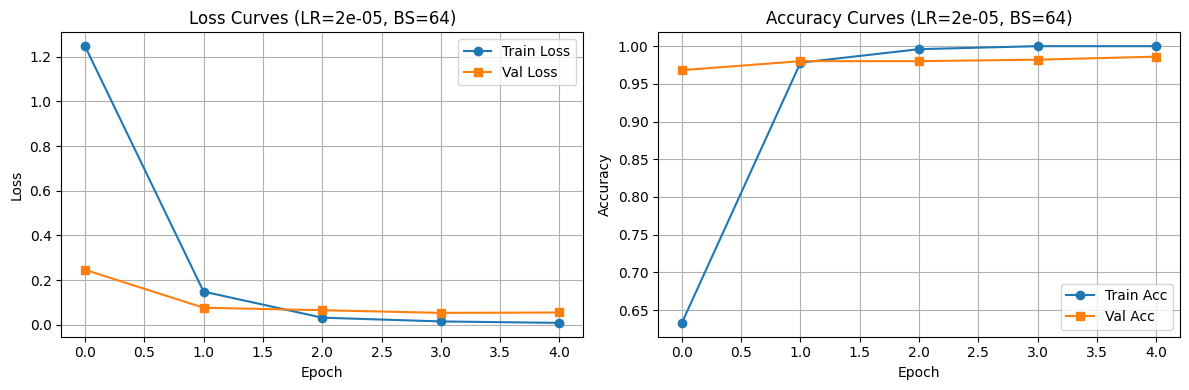


Training with LR=1e-05, BS=16 on cuda
Epoch 1: Train Loss=1.0163, Train Acc=0.7146, Val Loss=0.1430, Val Acc=0.9722
Epoch 2: Train Loss=0.1042, Train Acc=0.9856, Val Loss=0.0665, Val Acc=0.9781
Epoch 3: Train Loss=0.0302, Train Acc=0.9970, Val Loss=0.0534, Val Acc=0.9821
Epoch 4: Train Loss=0.0123, Train Acc=1.0000, Val Loss=0.0508, Val Acc=0.9861
Epoch 5: Train Loss=0.0072, Train Acc=1.0000, Val Loss=0.0495, Val Acc=0.9841


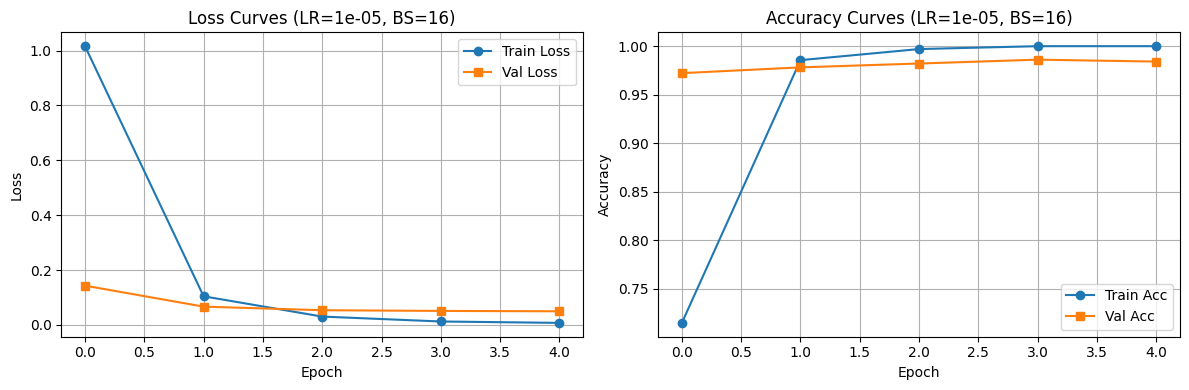


Training with LR=1e-05, BS=32 on cuda
Epoch 1: Train Loss=1.3402, Train Acc=0.6067, Val Loss=0.3330, Val Acc=0.9583
Epoch 2: Train Loss=0.2357, Train Acc=0.9652, Val Loss=0.0919, Val Acc=0.9781
Epoch 3: Train Loss=0.0670, Train Acc=0.9891, Val Loss=0.0672, Val Acc=0.9801
Epoch 4: Train Loss=0.0310, Train Acc=0.9975, Val Loss=0.0630, Val Acc=0.9821
Epoch 5: Train Loss=0.0175, Train Acc=0.9985, Val Loss=0.0554, Val Acc=0.9821


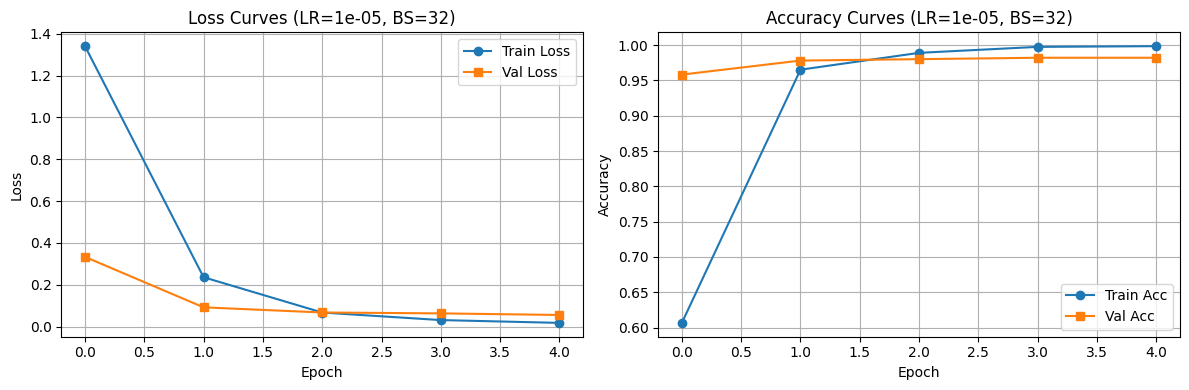


Training with LR=1e-05, BS=64 on cuda
Epoch 1: Train Loss=1.6746, Train Acc=0.4306, Val Loss=0.7832, Val Acc=0.8728
Epoch 2: Train Loss=0.5650, Train Acc=0.9090, Val Loss=0.1885, Val Acc=0.9682
Epoch 3: Train Loss=0.1753, Train Acc=0.9771, Val Loss=0.0882, Val Acc=0.9781
Epoch 4: Train Loss=0.0744, Train Acc=0.9925, Val Loss=0.0682, Val Acc=0.9761
Epoch 5: Train Loss=0.0418, Train Acc=0.9970, Val Loss=0.0578, Val Acc=0.9841


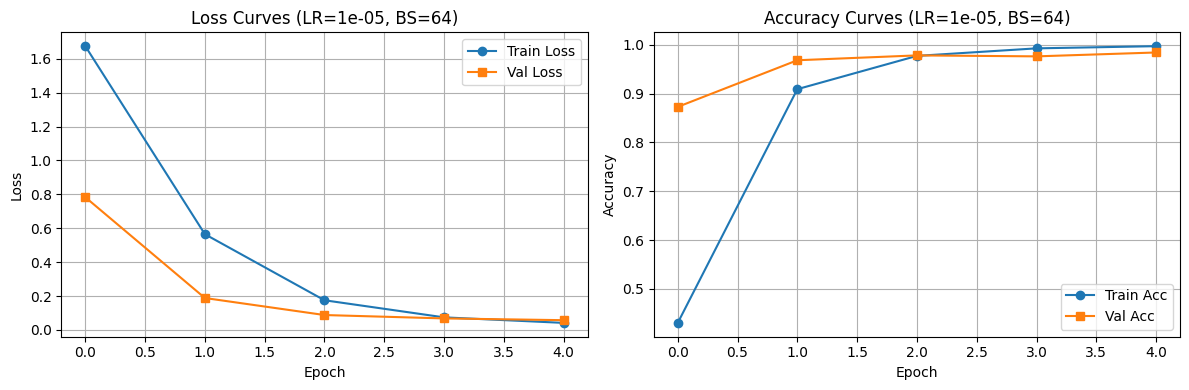

✅ Complete model saved to: saved_models/fold_1_complete_model


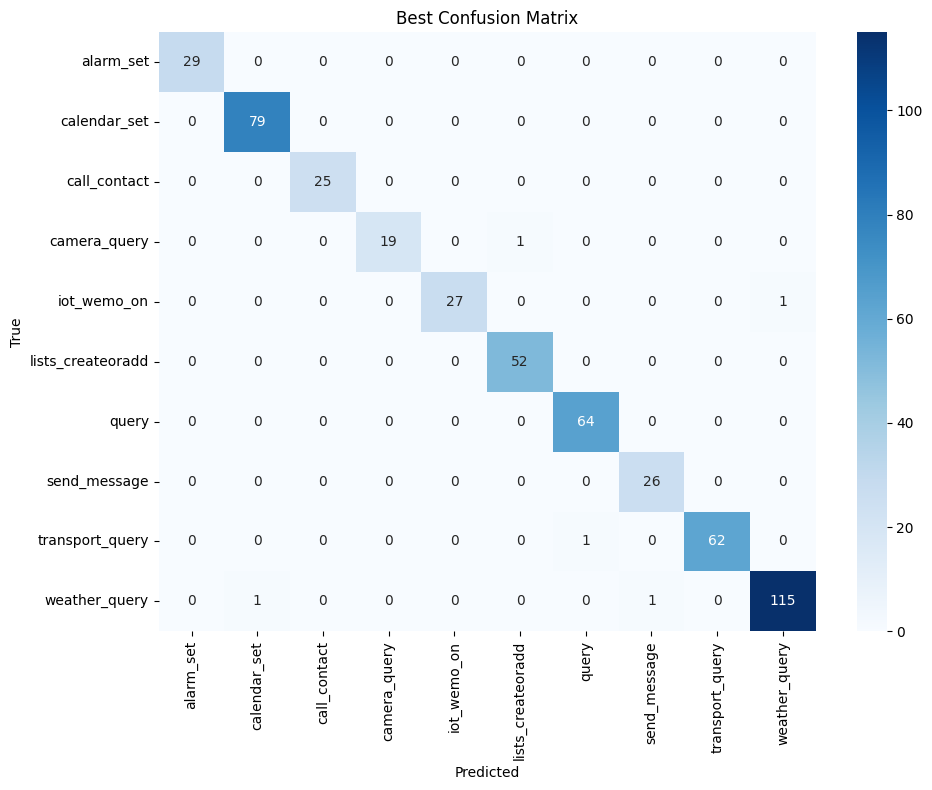

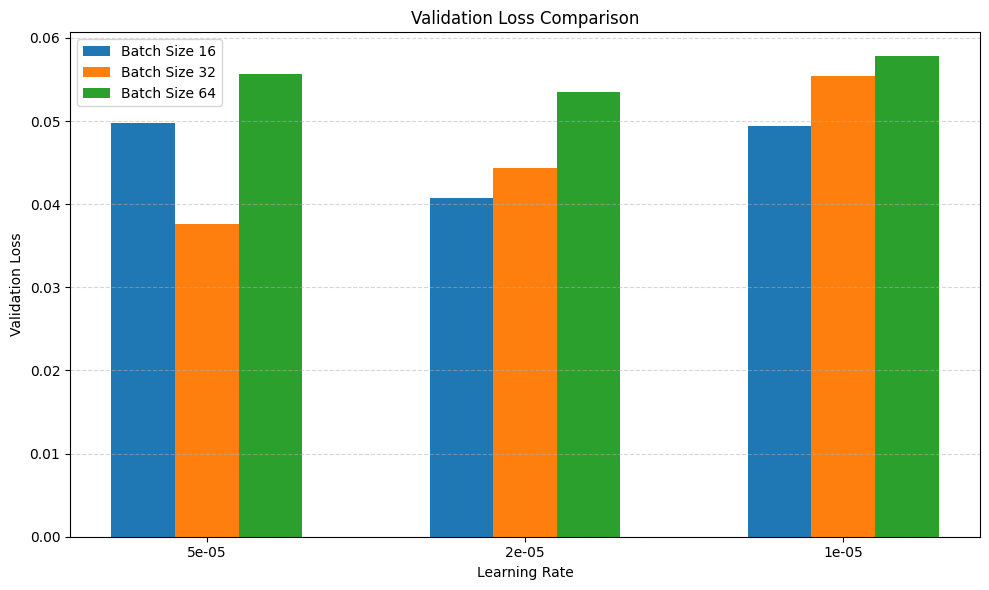


✅ Best Model Saved to: saved_models/fold_1_complete_model
Classification Report:
                    precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        29
     calendar_set       0.99      1.00      0.99        79
     call_contact       1.00      1.00      1.00        25
     camera_query       1.00      0.95      0.97        20
      iot_wemo_on       1.00      0.96      0.98        28
lists_createoradd       0.98      1.00      0.99        52
            query       0.98      1.00      0.99        64
     send_message       0.96      1.00      0.98        26
  transport_query       1.00      0.98      0.99        63
    weather_query       0.99      0.98      0.99       117

         accuracy                           0.99       503
        macro avg       0.99      0.99      0.99       503
     weighted avg       0.99      0.99      0.99       503



Some weights of BertModel were not initialized from the model checkpoint at avichr/heBERT and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully from: saved_models/fold_1_complete_model
📊 Number of classes: 10
🏷️ Intent labels: ['alarm_set', 'calendar_set', 'call_contact', 'camera_query', 'iot_wemo_on', 'lists_createoradd', 'query', 'send_message', 'transport_query', 'weather_query']

📊 Fold 1 Results:
   Accuracy: 0.9901
   Macro F1: 0.9893
   Weighted F1: 0.9900
   Best BS: 32, LR: 5e-05

========== Fold 2 ========== 

Training with LR=5e-05, BS=16 on cuda
Epoch 1: Train Loss=0.3515, Train Acc=0.8956, Val Loss=0.0273, Val Acc=0.9920
Epoch 2: Train Loss=0.0184, Train Acc=0.9965, Val Loss=0.0251, Val Acc=0.9920
Epoch 3: Train Loss=0.0041, Train Acc=0.9995, Val Loss=0.0285, Val Acc=0.9901
⏹ Early stopping at epoch 3


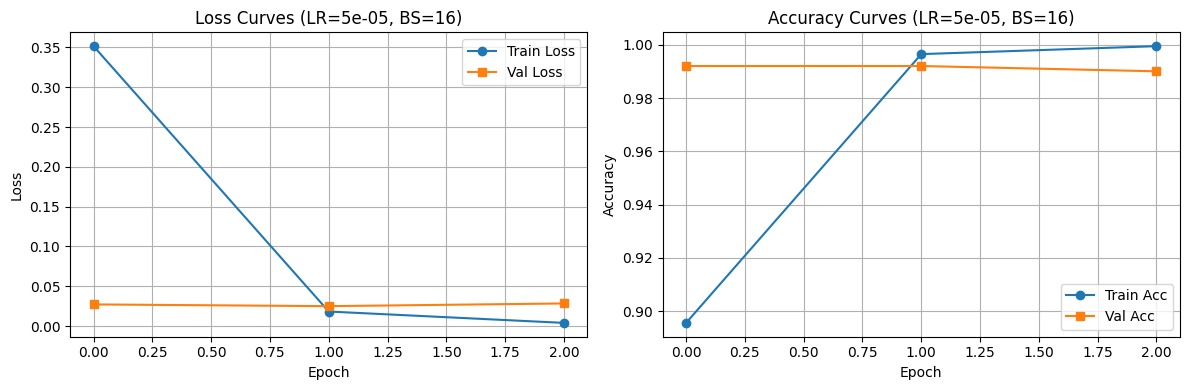


Training with LR=5e-05, BS=32 on cuda
Epoch 1: Train Loss=0.5045, Train Acc=0.8513, Val Loss=0.0220, Val Acc=0.9920
Epoch 2: Train Loss=0.0250, Train Acc=0.9935, Val Loss=0.0241, Val Acc=0.9920
⏹ Early stopping at epoch 2


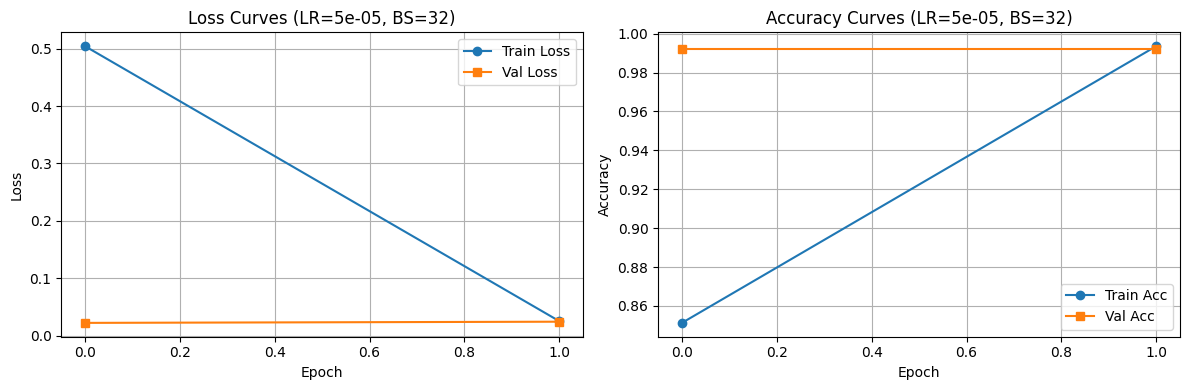


Training with LR=5e-05, BS=64 on cuda
Epoch 1: Train Loss=0.7304, Train Acc=0.7842, Val Loss=0.0375, Val Acc=0.9841
Epoch 2: Train Loss=0.0327, Train Acc=0.9910, Val Loss=0.0159, Val Acc=0.9920
Epoch 3: Train Loss=0.0178, Train Acc=0.9960, Val Loss=0.0187, Val Acc=0.9940
⏹ Early stopping at epoch 3


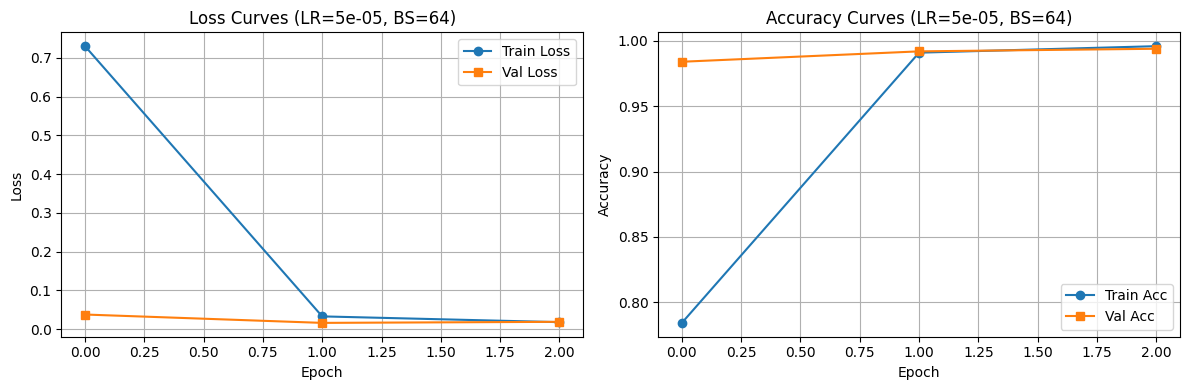


Training with LR=2e-05, BS=16 on cuda
Epoch 1: Train Loss=0.6439, Train Acc=0.8195, Val Loss=0.0397, Val Acc=0.9821
Epoch 2: Train Loss=0.0425, Train Acc=0.9901, Val Loss=0.0282, Val Acc=0.9881
Epoch 3: Train Loss=0.0084, Train Acc=1.0000, Val Loss=0.0189, Val Acc=0.9920
Epoch 4: Train Loss=0.0037, Train Acc=1.0000, Val Loss=0.0158, Val Acc=0.9920
Epoch 5: Train Loss=0.0022, Train Acc=1.0000, Val Loss=0.0144, Val Acc=0.9940


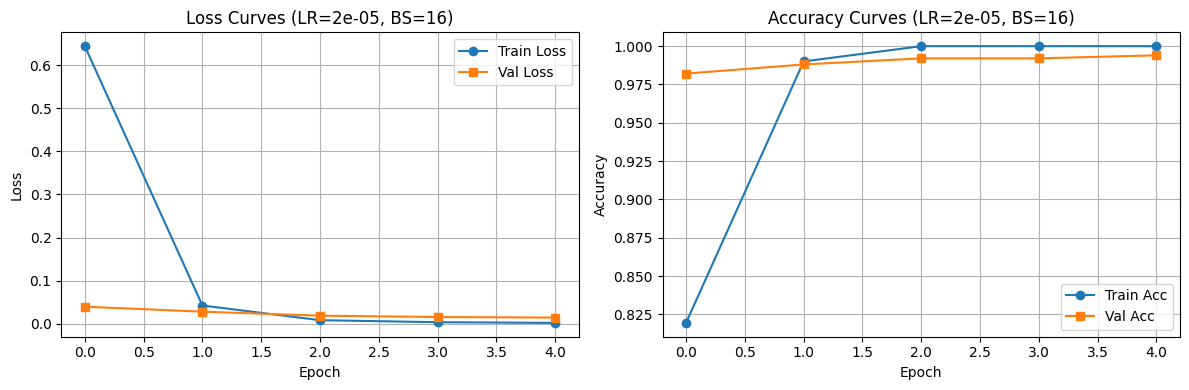


Training with LR=2e-05, BS=32 on cuda
Epoch 1: Train Loss=0.8410, Train Acc=0.7558, Val Loss=0.0654, Val Acc=0.9841
Epoch 2: Train Loss=0.0625, Train Acc=0.9881, Val Loss=0.0199, Val Acc=0.9980
Epoch 3: Train Loss=0.0152, Train Acc=1.0000, Val Loss=0.0101, Val Acc=0.9980
Epoch 4: Train Loss=0.0070, Train Acc=1.0000, Val Loss=0.0092, Val Acc=0.9960
Epoch 5: Train Loss=0.0039, Train Acc=1.0000, Val Loss=0.0054, Val Acc=1.0000


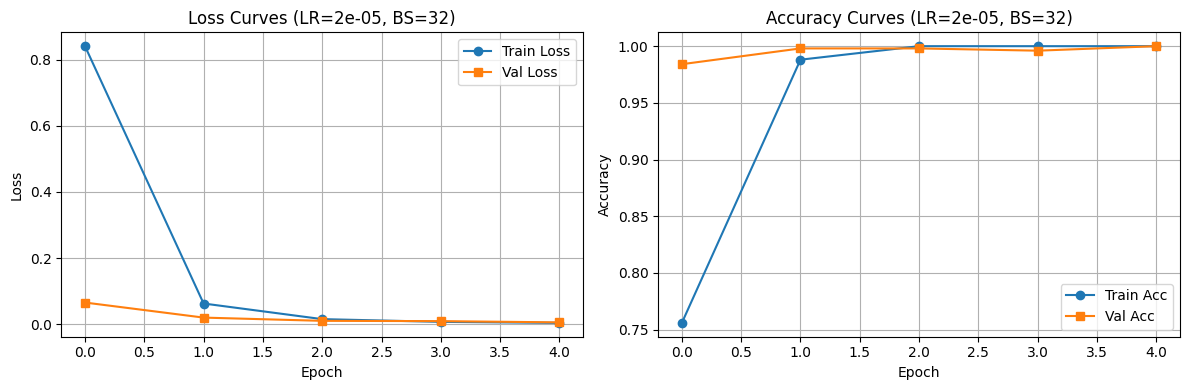


Training with LR=2e-05, BS=64 on cuda
Epoch 1: Train Loss=1.2584, Train Acc=0.6236, Val Loss=0.2360, Val Acc=0.9682
Epoch 2: Train Loss=0.1754, Train Acc=0.9697, Val Loss=0.0575, Val Acc=0.9861
Epoch 3: Train Loss=0.0455, Train Acc=0.9915, Val Loss=0.0231, Val Acc=0.9901
Epoch 4: Train Loss=0.0190, Train Acc=0.9985, Val Loss=0.0149, Val Acc=0.9960
Epoch 5: Train Loss=0.0102, Train Acc=0.9995, Val Loss=0.0117, Val Acc=0.9960


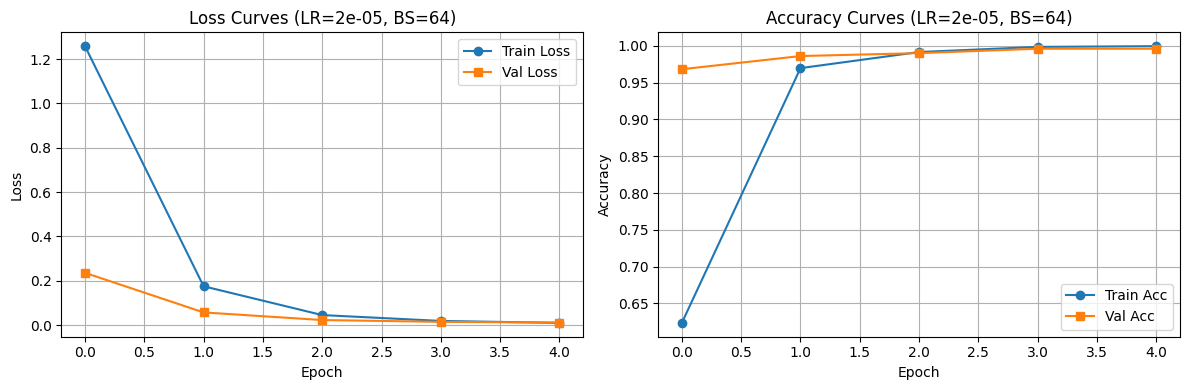


Training with LR=1e-05, BS=16 on cuda
Epoch 1: Train Loss=1.0276, Train Acc=0.7026, Val Loss=0.1413, Val Acc=0.9821
Epoch 2: Train Loss=0.1126, Train Acc=0.9851, Val Loss=0.0366, Val Acc=0.9901
Epoch 3: Train Loss=0.0324, Train Acc=0.9975, Val Loss=0.0231, Val Acc=0.9901
Epoch 4: Train Loss=0.0147, Train Acc=0.9985, Val Loss=0.0176, Val Acc=0.9940
Epoch 5: Train Loss=0.0079, Train Acc=1.0000, Val Loss=0.0191, Val Acc=0.9920
⏹ Early stopping at epoch 5


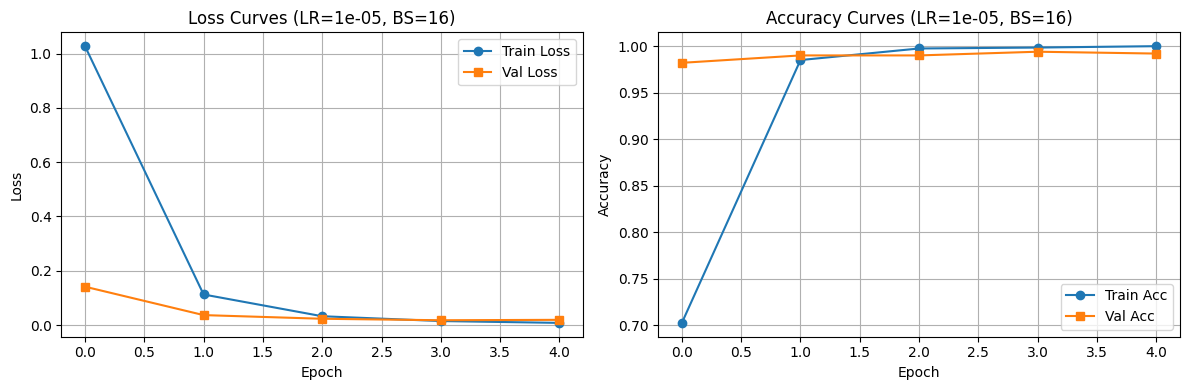


Training with LR=1e-05, BS=32 on cuda
Epoch 1: Train Loss=1.3334, Train Acc=0.6007, Val Loss=0.2784, Val Acc=0.9761
Epoch 2: Train Loss=0.2273, Train Acc=0.9717, Val Loss=0.0532, Val Acc=0.9920
Epoch 3: Train Loss=0.0727, Train Acc=0.9891, Val Loss=0.0264, Val Acc=0.9940
Epoch 4: Train Loss=0.0315, Train Acc=0.9970, Val Loss=0.0194, Val Acc=0.9940
Epoch 5: Train Loss=0.0165, Train Acc=0.9995, Val Loss=0.0133, Val Acc=0.9960


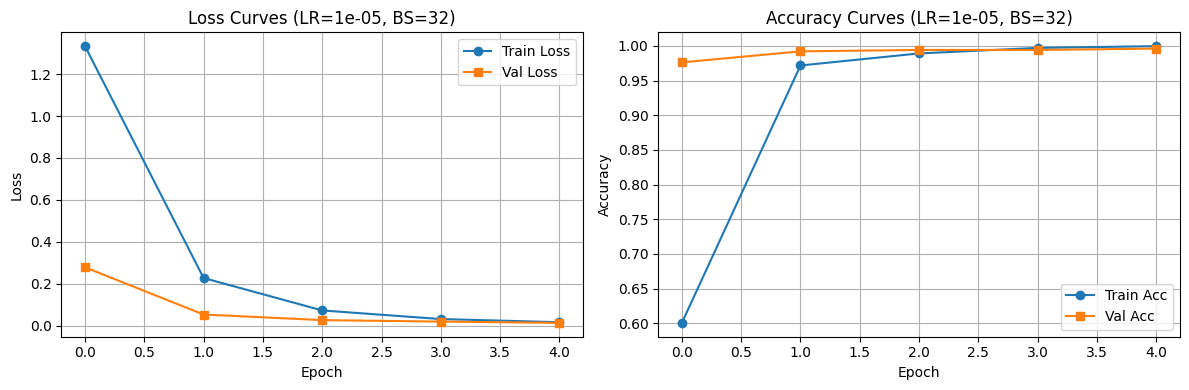


Training with LR=1e-05, BS=64 on cuda
Epoch 1: Train Loss=1.7987, Train Acc=0.3899, Val Loss=0.8900, Val Acc=0.8250
Epoch 2: Train Loss=0.6550, Train Acc=0.8772, Val Loss=0.2076, Val Acc=0.9722
Epoch 3: Train Loss=0.2058, Train Acc=0.9717, Val Loss=0.0701, Val Acc=0.9901
Epoch 4: Train Loss=0.0852, Train Acc=0.9891, Val Loss=0.0403, Val Acc=0.9940
Epoch 5: Train Loss=0.0488, Train Acc=0.9945, Val Loss=0.0303, Val Acc=0.9940


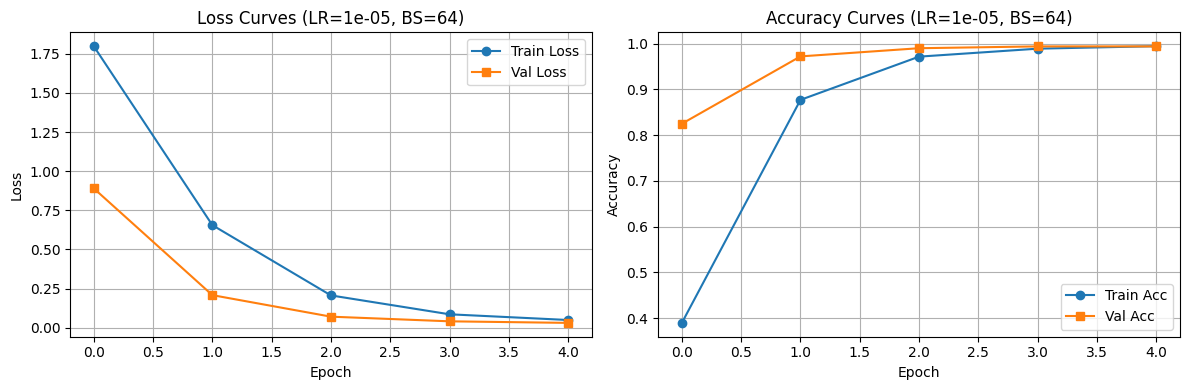

✅ Complete model saved to: saved_models/fold_2_complete_model


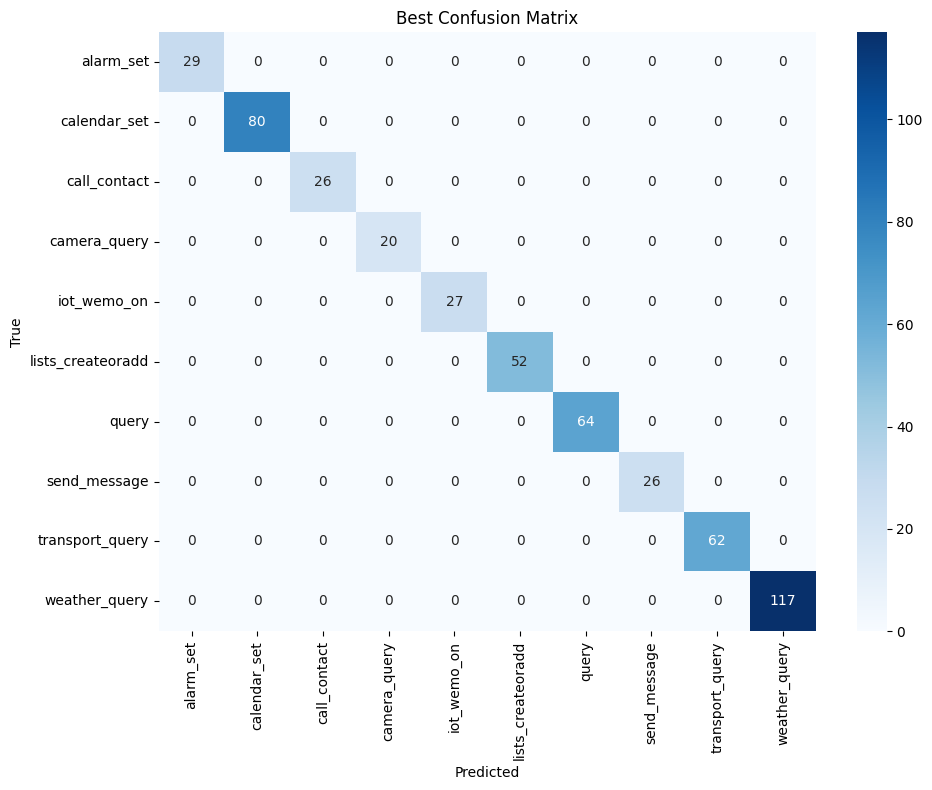

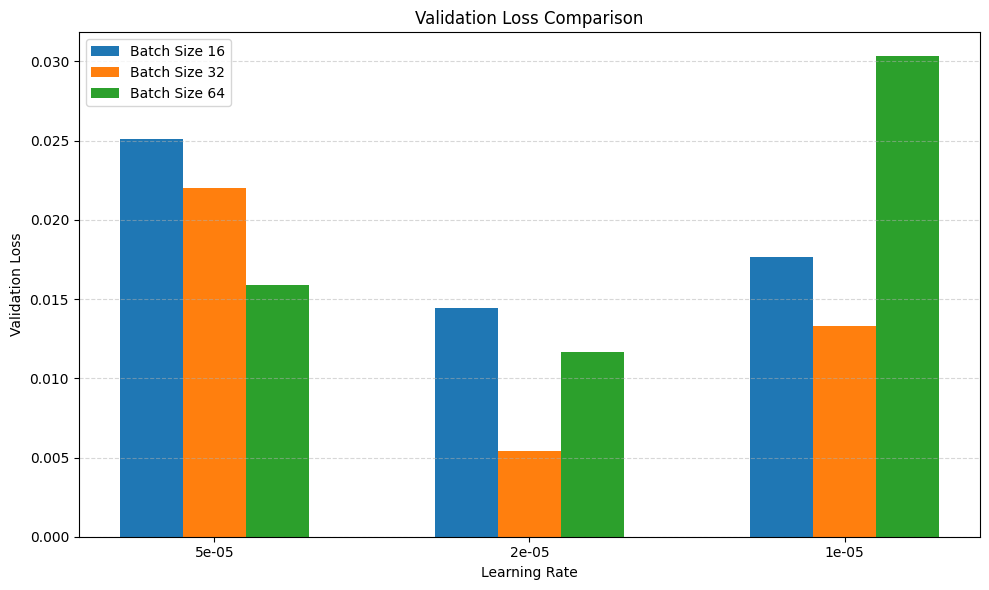


✅ Best Model Saved to: saved_models/fold_2_complete_model
Classification Report:
                    precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        29
     calendar_set       1.00      1.00      1.00        80
     call_contact       1.00      1.00      1.00        26
     camera_query       1.00      1.00      1.00        20
      iot_wemo_on       1.00      1.00      1.00        27
lists_createoradd       1.00      1.00      1.00        52
            query       1.00      1.00      1.00        64
     send_message       1.00      1.00      1.00        26
  transport_query       1.00      1.00      1.00        62
    weather_query       1.00      1.00      1.00       117

         accuracy                           1.00       503
        macro avg       1.00      1.00      1.00       503
     weighted avg       1.00      1.00      1.00       503



Some weights of BertModel were not initialized from the model checkpoint at avichr/heBERT and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully from: saved_models/fold_2_complete_model
📊 Number of classes: 10
🏷️ Intent labels: ['alarm_set', 'calendar_set', 'call_contact', 'camera_query', 'iot_wemo_on', 'lists_createoradd', 'query', 'send_message', 'transport_query', 'weather_query']

📊 Fold 2 Results:
   Accuracy: 1.0000
   Macro F1: 1.0000
   Weighted F1: 1.0000
   Best BS: 32, LR: 2e-05

========== Fold 3 ========== 

Training with LR=5e-05, BS=16 on cuda
Epoch 1: Train Loss=0.3448, Train Acc=0.9025, Val Loss=0.1048, Val Acc=0.9702
Epoch 2: Train Loss=0.0166, Train Acc=0.9965, Val Loss=0.0715, Val Acc=0.9821
Epoch 3: Train Loss=0.0069, Train Acc=0.9985, Val Loss=0.0624, Val Acc=0.9821
Epoch 4: Train Loss=0.0009, Train Acc=1.0000, Val Loss=0.0629, Val Acc=0.9841
⏹ Early stopping at epoch 4


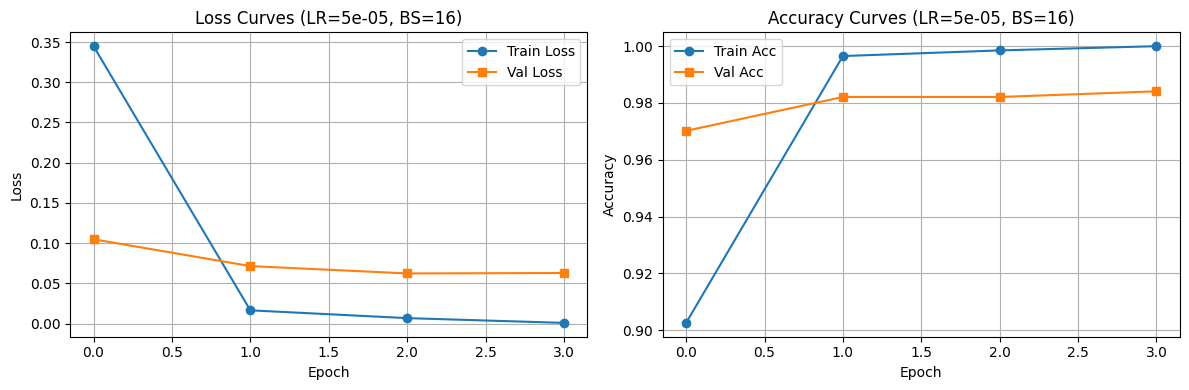


Training with LR=5e-05, BS=32 on cuda
Epoch 1: Train Loss=0.4626, Train Acc=0.8647, Val Loss=0.0793, Val Acc=0.9761
Epoch 2: Train Loss=0.0165, Train Acc=0.9965, Val Loss=0.0764, Val Acc=0.9761
Epoch 3: Train Loss=0.0084, Train Acc=0.9990, Val Loss=0.0449, Val Acc=0.9901
Epoch 4: Train Loss=0.0029, Train Acc=0.9990, Val Loss=0.0513, Val Acc=0.9881
⏹ Early stopping at epoch 4


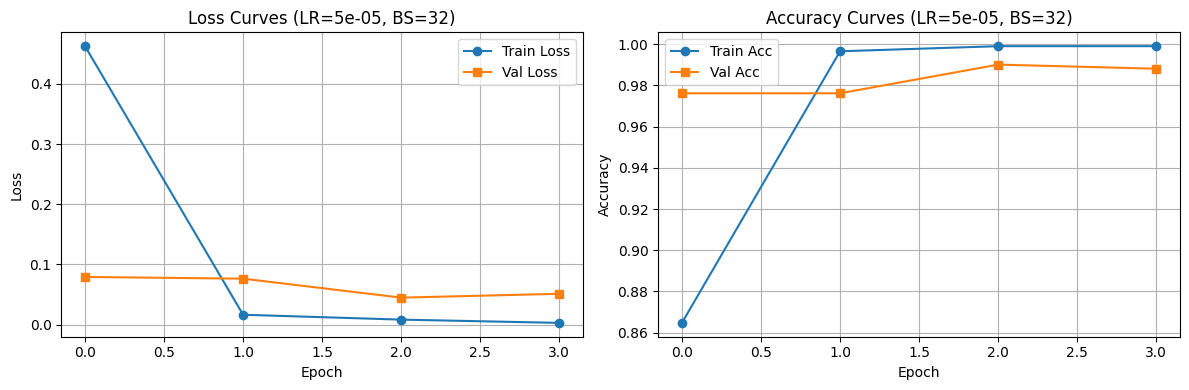


Training with LR=5e-05, BS=64 on cuda
Epoch 1: Train Loss=0.6543, Train Acc=0.8036, Val Loss=0.0547, Val Acc=0.9861
Epoch 2: Train Loss=0.0262, Train Acc=0.9955, Val Loss=0.0597, Val Acc=0.9801
⏹ Early stopping at epoch 2


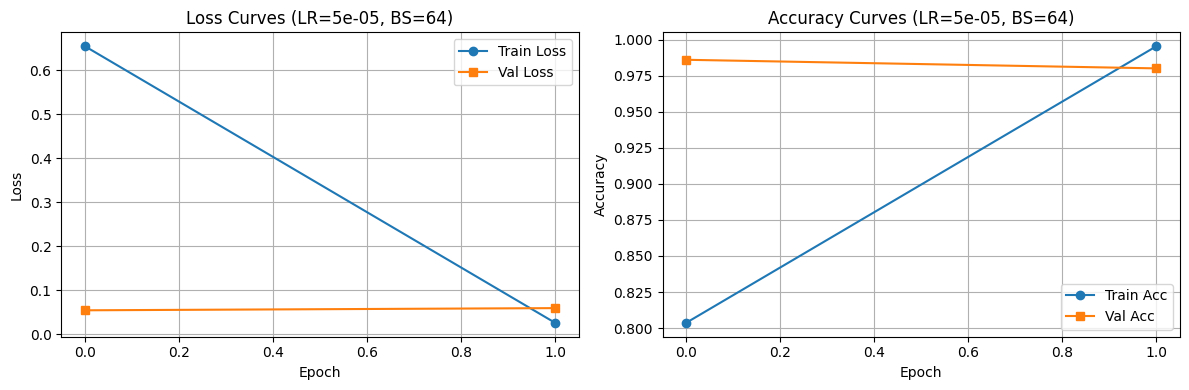


Training with LR=2e-05, BS=16 on cuda
Epoch 1: Train Loss=0.6022, Train Acc=0.8319, Val Loss=0.0629, Val Acc=0.9841
Epoch 2: Train Loss=0.0292, Train Acc=0.9955, Val Loss=0.0426, Val Acc=0.9901
Epoch 3: Train Loss=0.0104, Train Acc=0.9995, Val Loss=0.0421, Val Acc=0.9901
Epoch 4: Train Loss=0.0038, Train Acc=1.0000, Val Loss=0.0392, Val Acc=0.9901
Epoch 5: Train Loss=0.0024, Train Acc=1.0000, Val Loss=0.0415, Val Acc=0.9920
⏹ Early stopping at epoch 5


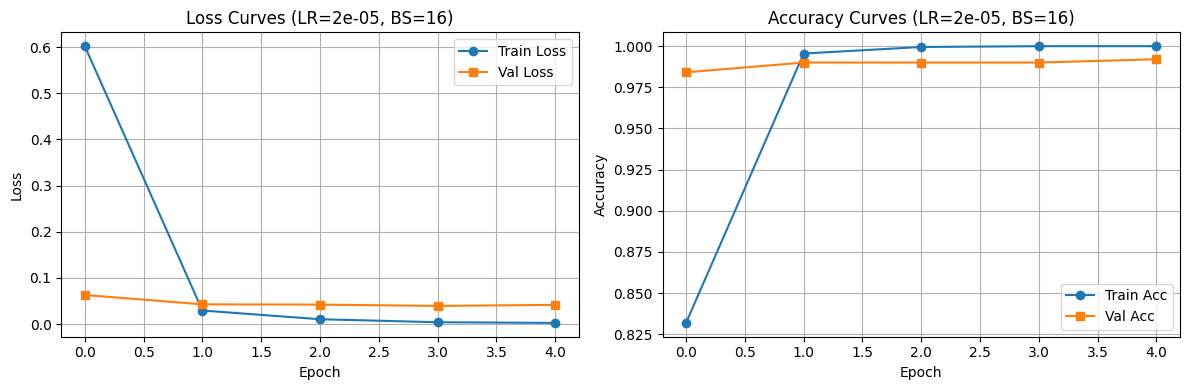


Training with LR=2e-05, BS=32 on cuda
Epoch 1: Train Loss=0.8804, Train Acc=0.7494, Val Loss=0.1226, Val Acc=0.9722
Epoch 2: Train Loss=0.0681, Train Acc=0.9891, Val Loss=0.0541, Val Acc=0.9841
Epoch 3: Train Loss=0.0164, Train Acc=0.9990, Val Loss=0.0458, Val Acc=0.9841
Epoch 4: Train Loss=0.0071, Train Acc=1.0000, Val Loss=0.0433, Val Acc=0.9861
Epoch 5: Train Loss=0.0044, Train Acc=1.0000, Val Loss=0.0434, Val Acc=0.9881
⏹ Early stopping at epoch 5


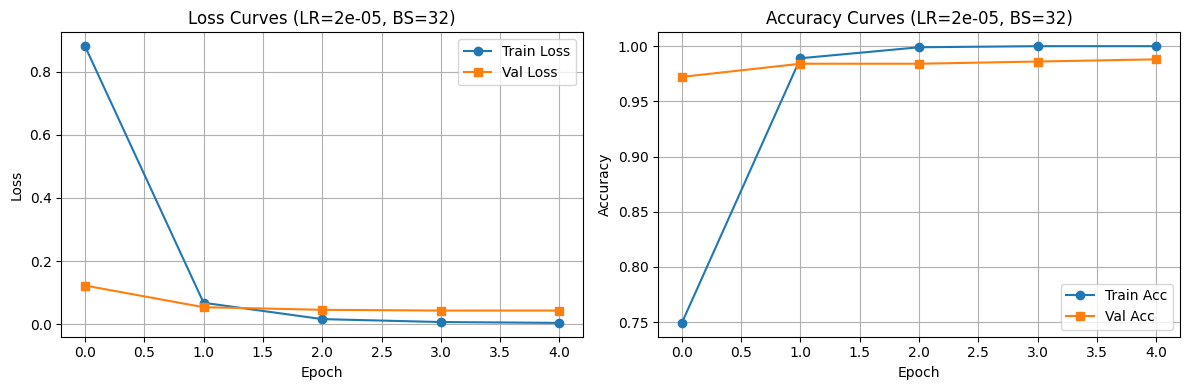


Training with LR=2e-05, BS=64 on cuda
Epoch 1: Train Loss=1.1868, Train Acc=0.6643, Val Loss=0.2395, Val Acc=0.9682
Epoch 2: Train Loss=0.1458, Train Acc=0.9751, Val Loss=0.0705, Val Acc=0.9801
Epoch 3: Train Loss=0.0366, Train Acc=0.9950, Val Loss=0.0587, Val Acc=0.9841
Epoch 4: Train Loss=0.0152, Train Acc=0.9985, Val Loss=0.0542, Val Acc=0.9841
Epoch 5: Train Loss=0.0092, Train Acc=1.0000, Val Loss=0.0535, Val Acc=0.9781


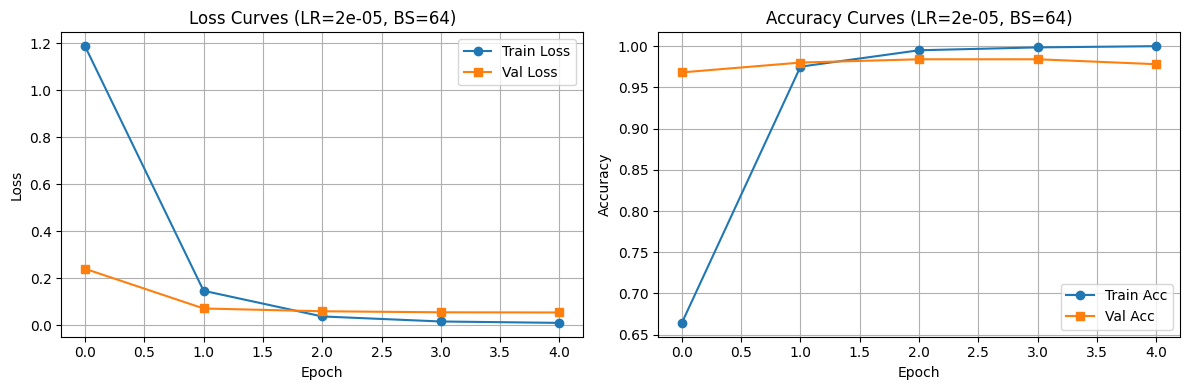


Training with LR=1e-05, BS=16 on cuda
Epoch 1: Train Loss=0.9951, Train Acc=0.7285, Val Loss=0.1449, Val Acc=0.9662
Epoch 2: Train Loss=0.0950, Train Acc=0.9846, Val Loss=0.0586, Val Acc=0.9781
Epoch 3: Train Loss=0.0287, Train Acc=0.9975, Val Loss=0.0605, Val Acc=0.9781
⏹ Early stopping at epoch 3


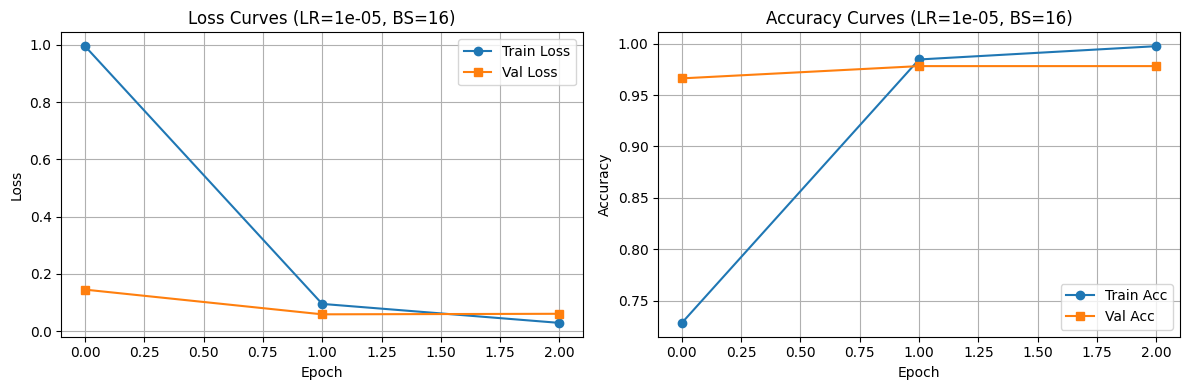


Training with LR=1e-05, BS=32 on cuda
Epoch 1: Train Loss=1.3302, Train Acc=0.5992, Val Loss=0.3282, Val Acc=0.9563
Epoch 2: Train Loss=0.2221, Train Acc=0.9642, Val Loss=0.0881, Val Acc=0.9801
Epoch 3: Train Loss=0.0699, Train Acc=0.9910, Val Loss=0.0615, Val Acc=0.9801
Epoch 4: Train Loss=0.0269, Train Acc=0.9985, Val Loss=0.0517, Val Acc=0.9841
Epoch 5: Train Loss=0.0139, Train Acc=1.0000, Val Loss=0.0529, Val Acc=0.9801
⏹ Early stopping at epoch 5


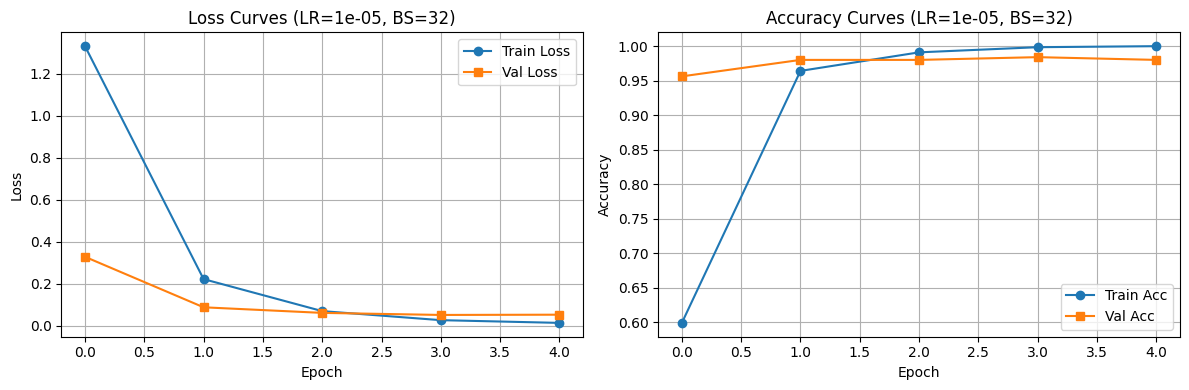


Training with LR=1e-05, BS=64 on cuda
Epoch 1: Train Loss=1.7380, Train Acc=0.4063, Val Loss=0.8783, Val Acc=0.8867
Epoch 2: Train Loss=0.6281, Train Acc=0.8846, Val Loss=0.2187, Val Acc=0.9642
Epoch 3: Train Loss=0.1951, Train Acc=0.9741, Val Loss=0.0917, Val Acc=0.9801
Epoch 4: Train Loss=0.0858, Train Acc=0.9891, Val Loss=0.0713, Val Acc=0.9742
Epoch 5: Train Loss=0.0462, Train Acc=0.9965, Val Loss=0.0557, Val Acc=0.9821


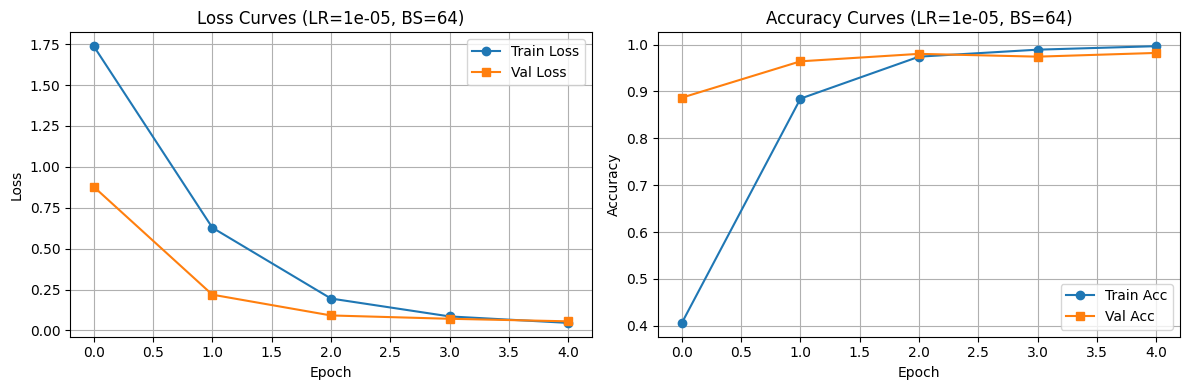

✅ Complete model saved to: saved_models/fold_3_complete_model


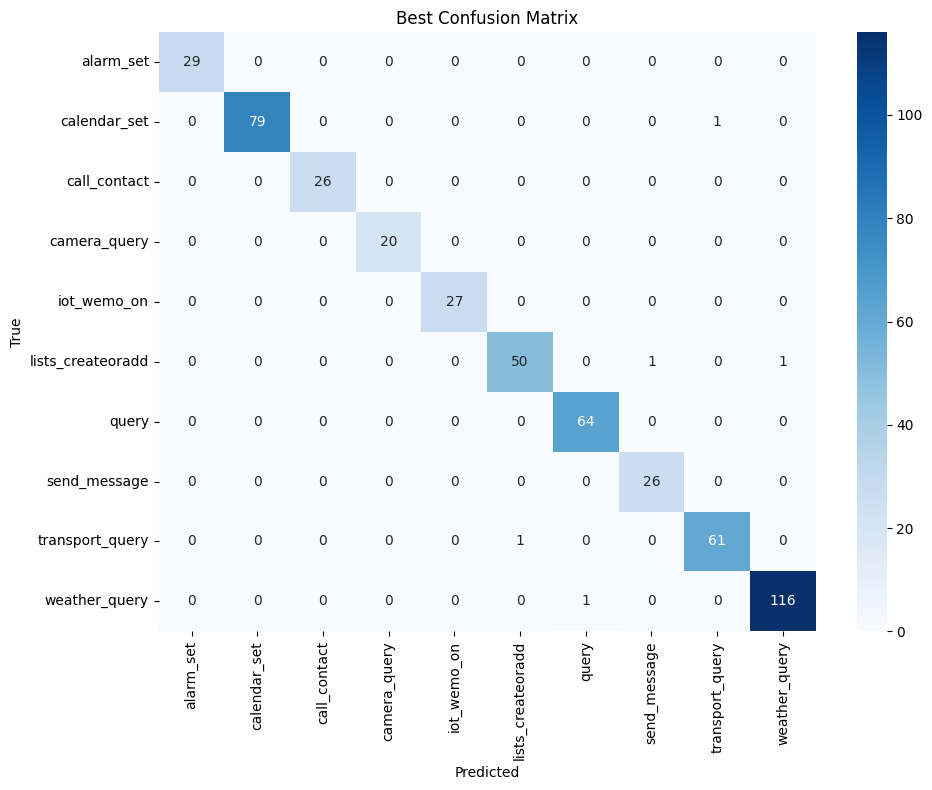

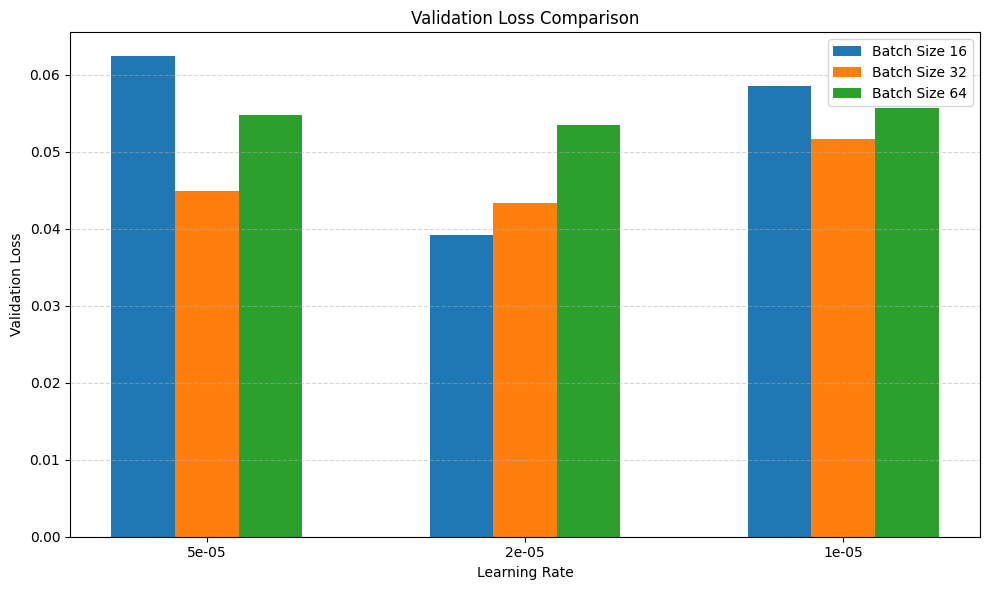


✅ Best Model Saved to: saved_models/fold_3_complete_model
Classification Report:
                    precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        29
     calendar_set       1.00      0.99      0.99        80
     call_contact       1.00      1.00      1.00        26
     camera_query       1.00      1.00      1.00        20
      iot_wemo_on       1.00      1.00      1.00        27
lists_createoradd       0.98      0.96      0.97        52
            query       0.98      1.00      0.99        64
     send_message       0.96      1.00      0.98        26
  transport_query       0.98      0.98      0.98        62
    weather_query       0.99      0.99      0.99       117

         accuracy                           0.99       503
        macro avg       0.99      0.99      0.99       503
     weighted avg       0.99      0.99      0.99       503



Some weights of BertModel were not initialized from the model checkpoint at avichr/heBERT and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully from: saved_models/fold_3_complete_model
📊 Number of classes: 10
🏷️ Intent labels: ['alarm_set', 'calendar_set', 'call_contact', 'camera_query', 'iot_wemo_on', 'lists_createoradd', 'query', 'send_message', 'transport_query', 'weather_query']

📊 Fold 3 Results:
   Accuracy: 0.9901
   Macro F1: 0.9913
   Weighted F1: 0.9901
   Best BS: 16, LR: 2e-05

========== Fold 4 ========== 

Training with LR=5e-05, BS=16 on cuda
Epoch 1: Train Loss=0.3485, Train Acc=0.8956, Val Loss=0.0579, Val Acc=0.9821
Epoch 2: Train Loss=0.0215, Train Acc=0.9965, Val Loss=0.0448, Val Acc=0.9901
Epoch 3: Train Loss=0.0021, Train Acc=1.0000, Val Loss=0.0344, Val Acc=0.9920
Epoch 4: Train Loss=0.0008, Train Acc=1.0000, Val Loss=0.0309, Val Acc=0.9940
Epoch 5: Train Loss=0.0006, Train Acc=1.0000, Val Loss=0.0304, Val Acc=0.9940


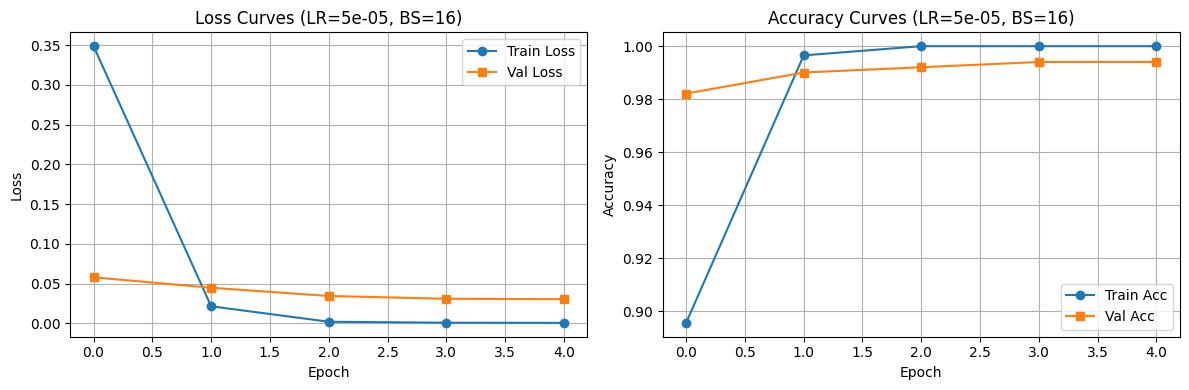


Training with LR=5e-05, BS=32 on cuda
Epoch 1: Train Loss=0.4974, Train Acc=0.8563, Val Loss=0.0459, Val Acc=0.9841
Epoch 2: Train Loss=0.0223, Train Acc=0.9950, Val Loss=0.0371, Val Acc=0.9881
Epoch 3: Train Loss=0.0042, Train Acc=0.9995, Val Loss=0.0252, Val Acc=0.9940
Epoch 4: Train Loss=0.0019, Train Acc=1.0000, Val Loss=0.0287, Val Acc=0.9920
⏹ Early stopping at epoch 4


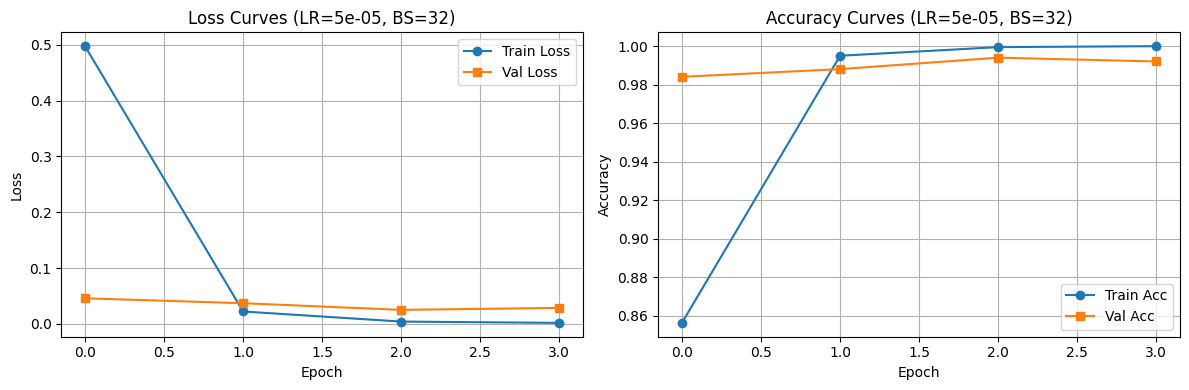


Training with LR=5e-05, BS=64 on cuda
Epoch 1: Train Loss=0.7228, Train Acc=0.7792, Val Loss=0.0608, Val Acc=0.9861
Epoch 2: Train Loss=0.0395, Train Acc=0.9906, Val Loss=0.0342, Val Acc=0.9901
Epoch 3: Train Loss=0.0100, Train Acc=0.9985, Val Loss=0.0240, Val Acc=0.9920
Epoch 4: Train Loss=0.0076, Train Acc=0.9990, Val Loss=0.0296, Val Acc=0.9881
⏹ Early stopping at epoch 4


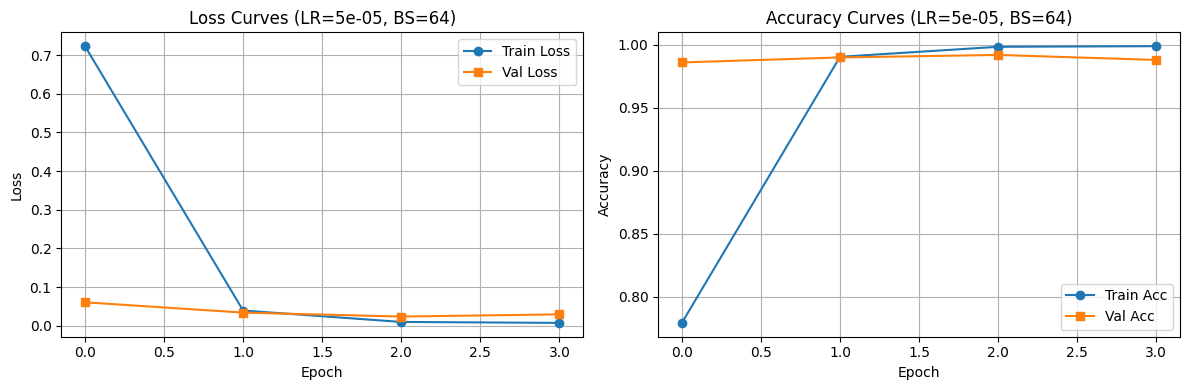


Training with LR=2e-05, BS=16 on cuda
Epoch 1: Train Loss=0.6337, Train Acc=0.8245, Val Loss=0.0443, Val Acc=0.9881
Epoch 2: Train Loss=0.0385, Train Acc=0.9925, Val Loss=0.0267, Val Acc=0.9920
Epoch 3: Train Loss=0.0107, Train Acc=0.9990, Val Loss=0.0312, Val Acc=0.9901
⏹ Early stopping at epoch 3


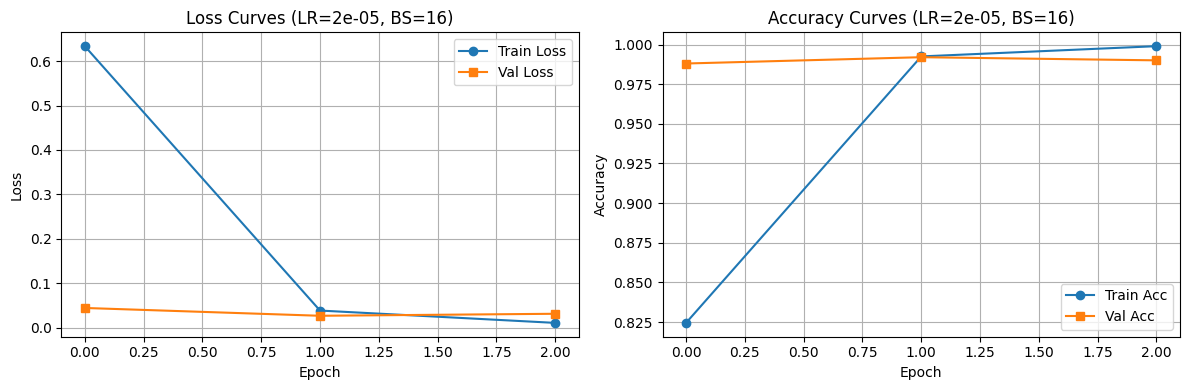


Training with LR=2e-05, BS=32 on cuda
Epoch 1: Train Loss=0.8633, Train Acc=0.7553, Val Loss=0.0849, Val Acc=0.9821
Epoch 2: Train Loss=0.0675, Train Acc=0.9896, Val Loss=0.0278, Val Acc=0.9920
Epoch 3: Train Loss=0.0188, Train Acc=0.9975, Val Loss=0.0197, Val Acc=0.9960
Epoch 4: Train Loss=0.0068, Train Acc=1.0000, Val Loss=0.0206, Val Acc=0.9901
⏹ Early stopping at epoch 4


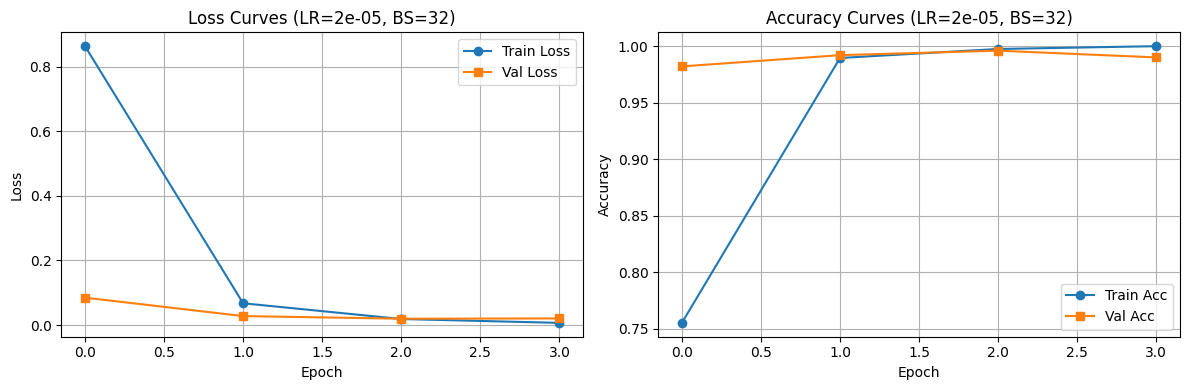


Training with LR=2e-05, BS=64 on cuda
Epoch 1: Train Loss=1.1123, Train Acc=0.6663, Val Loss=0.1929, Val Acc=0.9583
Epoch 2: Train Loss=0.1416, Train Acc=0.9766, Val Loss=0.0512, Val Acc=0.9881
Epoch 3: Train Loss=0.0378, Train Acc=0.9960, Val Loss=0.0370, Val Acc=0.9881
Epoch 4: Train Loss=0.0161, Train Acc=0.9990, Val Loss=0.0288, Val Acc=0.9920
Epoch 5: Train Loss=0.0091, Train Acc=1.0000, Val Loss=0.0318, Val Acc=0.9881
⏹ Early stopping at epoch 5


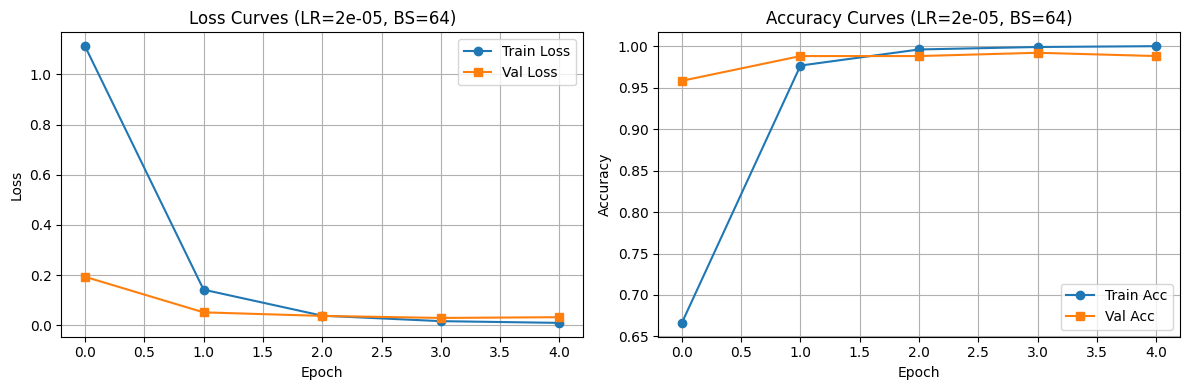


Training with LR=1e-05, BS=16 on cuda
Epoch 1: Train Loss=0.9978, Train Acc=0.7240, Val Loss=0.1349, Val Acc=0.9742
Epoch 2: Train Loss=0.1081, Train Acc=0.9811, Val Loss=0.0478, Val Acc=0.9861
Epoch 3: Train Loss=0.0324, Train Acc=0.9945, Val Loss=0.0424, Val Acc=0.9881
Epoch 4: Train Loss=0.0120, Train Acc=1.0000, Val Loss=0.0362, Val Acc=0.9920
Epoch 5: Train Loss=0.0063, Train Acc=1.0000, Val Loss=0.0338, Val Acc=0.9901


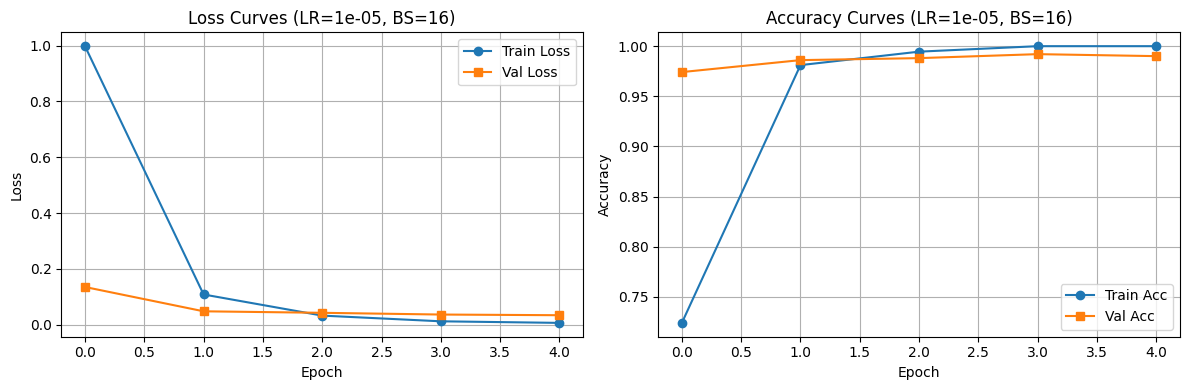


Training with LR=1e-05, BS=32 on cuda
Epoch 1: Train Loss=1.2528, Train Acc=0.6221, Val Loss=0.3041, Val Acc=0.9602
Epoch 2: Train Loss=0.2154, Train Acc=0.9672, Val Loss=0.0730, Val Acc=0.9821
Epoch 3: Train Loss=0.0656, Train Acc=0.9915, Val Loss=0.0421, Val Acc=0.9920
Epoch 4: Train Loss=0.0288, Train Acc=0.9985, Val Loss=0.0316, Val Acc=0.9920
Epoch 5: Train Loss=0.0181, Train Acc=0.9985, Val Loss=0.0338, Val Acc=0.9920
⏹ Early stopping at epoch 5


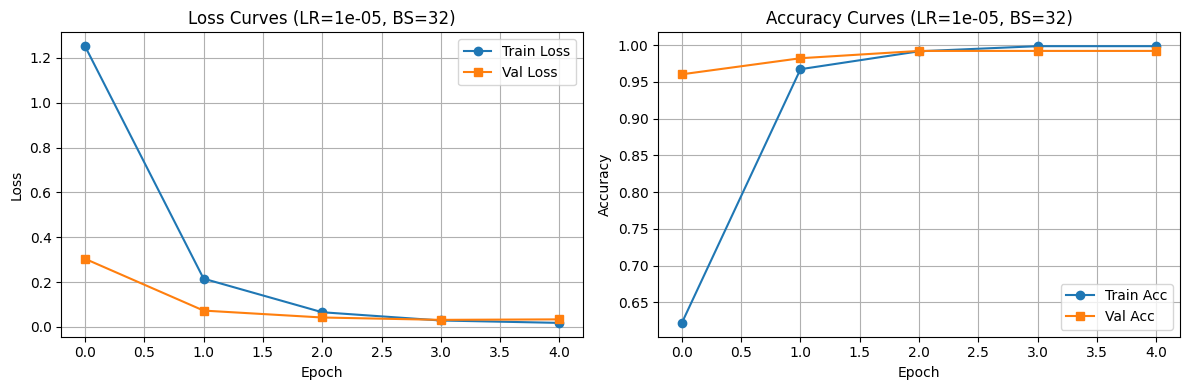


Training with LR=1e-05, BS=64 on cuda
Epoch 1: Train Loss=1.6812, Train Acc=0.4515, Val Loss=0.8273, Val Acc=0.8728
Epoch 2: Train Loss=0.6031, Train Acc=0.8866, Val Loss=0.1979, Val Acc=0.9722
Epoch 3: Train Loss=0.1897, Train Acc=0.9727, Val Loss=0.0858, Val Acc=0.9821
Epoch 4: Train Loss=0.0851, Train Acc=0.9881, Val Loss=0.0540, Val Acc=0.9861
Epoch 5: Train Loss=0.0433, Train Acc=0.9970, Val Loss=0.0407, Val Acc=0.9901


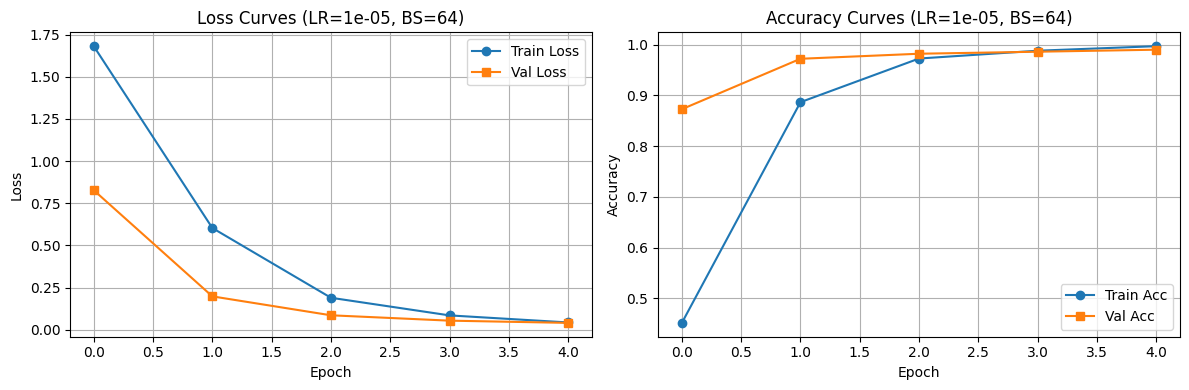

✅ Complete model saved to: saved_models/fold_4_complete_model


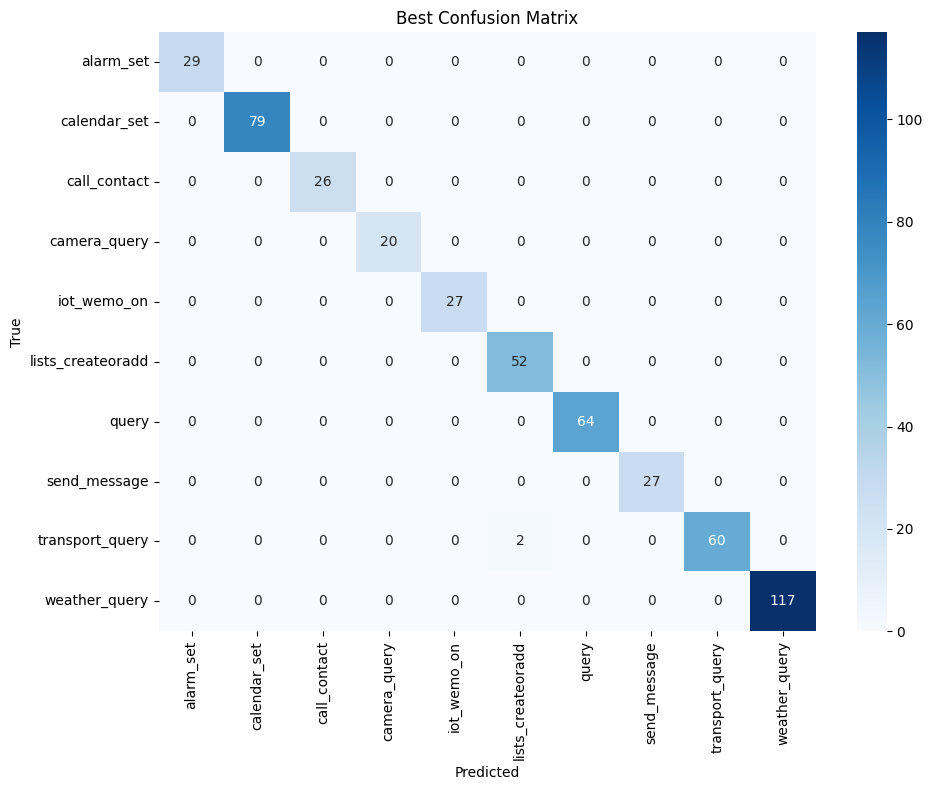

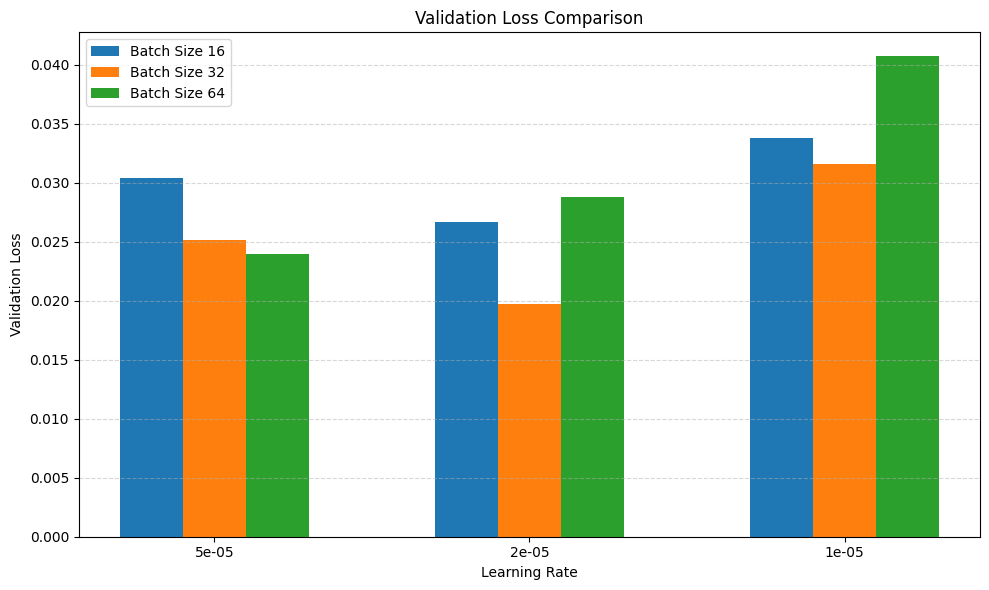


✅ Best Model Saved to: saved_models/fold_4_complete_model
Classification Report:
                    precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        29
     calendar_set       1.00      1.00      1.00        79
     call_contact       1.00      1.00      1.00        26
     camera_query       1.00      1.00      1.00        20
      iot_wemo_on       1.00      1.00      1.00        27
lists_createoradd       0.96      1.00      0.98        52
            query       1.00      1.00      1.00        64
     send_message       1.00      1.00      1.00        27
  transport_query       1.00      0.97      0.98        62
    weather_query       1.00      1.00      1.00       117

         accuracy                           1.00       503
        macro avg       1.00      1.00      1.00       503
     weighted avg       1.00      1.00      1.00       503



Some weights of BertModel were not initialized from the model checkpoint at avichr/heBERT and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully from: saved_models/fold_4_complete_model
📊 Number of classes: 10
🏷️ Intent labels: ['alarm_set', 'calendar_set', 'call_contact', 'camera_query', 'iot_wemo_on', 'lists_createoradd', 'query', 'send_message', 'transport_query', 'weather_query']

📊 Fold 4 Results:
   Accuracy: 0.9960
   Macro F1: 0.9965
   Weighted F1: 0.9960
   Best BS: 32, LR: 2e-05

========== Fold 5 ========== 

Training with LR=5e-05, BS=16 on cuda
Epoch 1: Train Loss=0.3587, Train Acc=0.8951, Val Loss=0.1078, Val Acc=0.9701
Epoch 2: Train Loss=0.0250, Train Acc=0.9930, Val Loss=0.0623, Val Acc=0.9781
Epoch 3: Train Loss=0.0201, Train Acc=0.9950, Val Loss=0.0714, Val Acc=0.9801
⏹ Early stopping at epoch 3


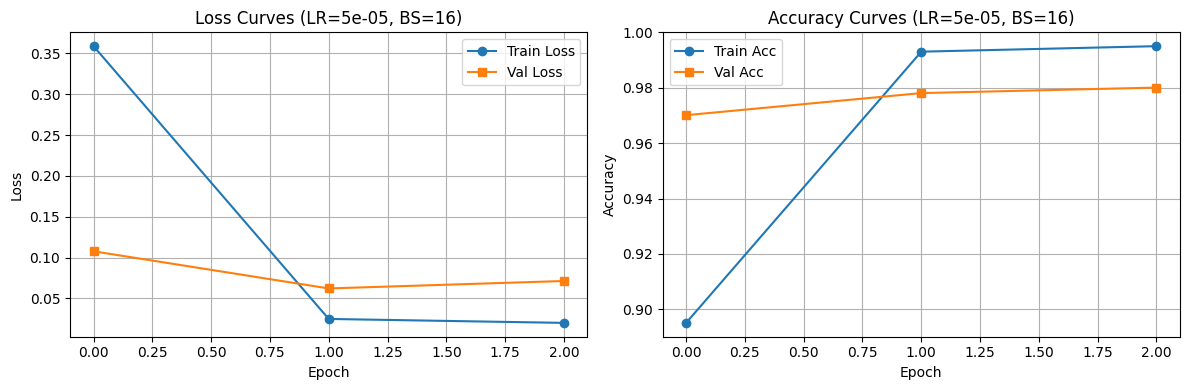


Training with LR=5e-05, BS=32 on cuda
Epoch 1: Train Loss=0.4564, Train Acc=0.8832, Val Loss=0.0745, Val Acc=0.9821
Epoch 2: Train Loss=0.0161, Train Acc=0.9965, Val Loss=0.0442, Val Acc=0.9900
Epoch 3: Train Loss=0.0053, Train Acc=0.9995, Val Loss=0.0393, Val Acc=0.9900
Epoch 4: Train Loss=0.0012, Train Acc=1.0000, Val Loss=0.0347, Val Acc=0.9920
Epoch 5: Train Loss=0.0012, Train Acc=1.0000, Val Loss=0.0321, Val Acc=0.9920


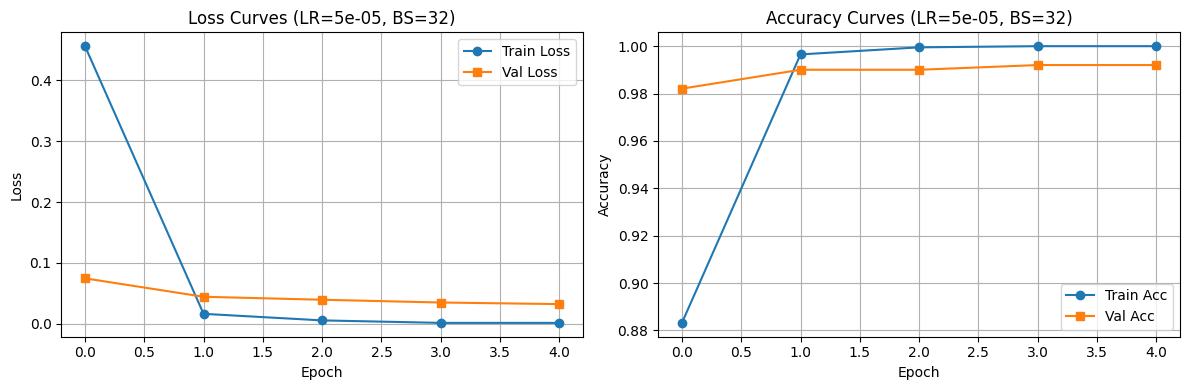


Training with LR=5e-05, BS=64 on cuda
Epoch 1: Train Loss=0.6545, Train Acc=0.8086, Val Loss=0.0648, Val Acc=0.9761
Epoch 2: Train Loss=0.0340, Train Acc=0.9925, Val Loss=0.0343, Val Acc=0.9880
Epoch 3: Train Loss=0.0085, Train Acc=0.9995, Val Loss=0.0335, Val Acc=0.9920
Epoch 4: Train Loss=0.0038, Train Acc=0.9995, Val Loss=0.0203, Val Acc=0.9940
Epoch 5: Train Loss=0.0016, Train Acc=1.0000, Val Loss=0.0210, Val Acc=0.9940
⏹ Early stopping at epoch 5


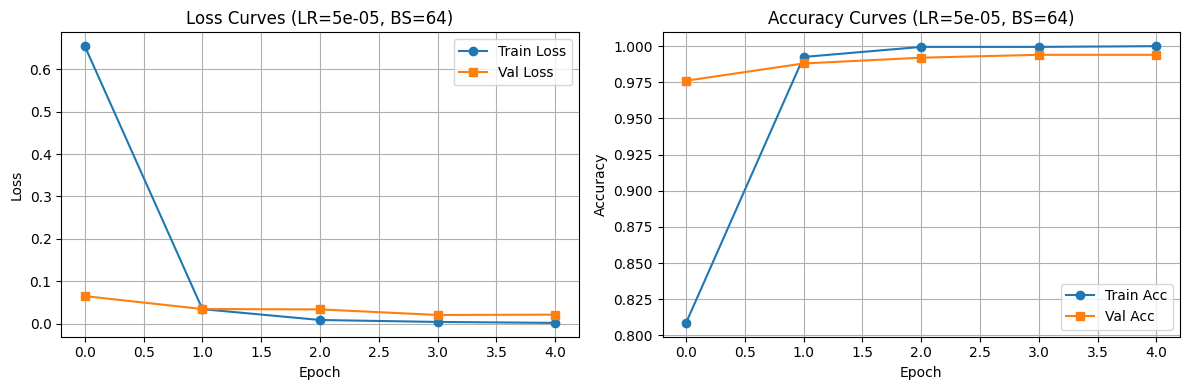


Training with LR=2e-05, BS=16 on cuda
Epoch 1: Train Loss=0.6355, Train Acc=0.8250, Val Loss=0.0696, Val Acc=0.9781
Epoch 2: Train Loss=0.0350, Train Acc=0.9960, Val Loss=0.0348, Val Acc=0.9900
Epoch 3: Train Loss=0.0143, Train Acc=0.9970, Val Loss=0.0281, Val Acc=0.9920
Epoch 4: Train Loss=0.0060, Train Acc=0.9990, Val Loss=0.0301, Val Acc=0.9920
⏹ Early stopping at epoch 4


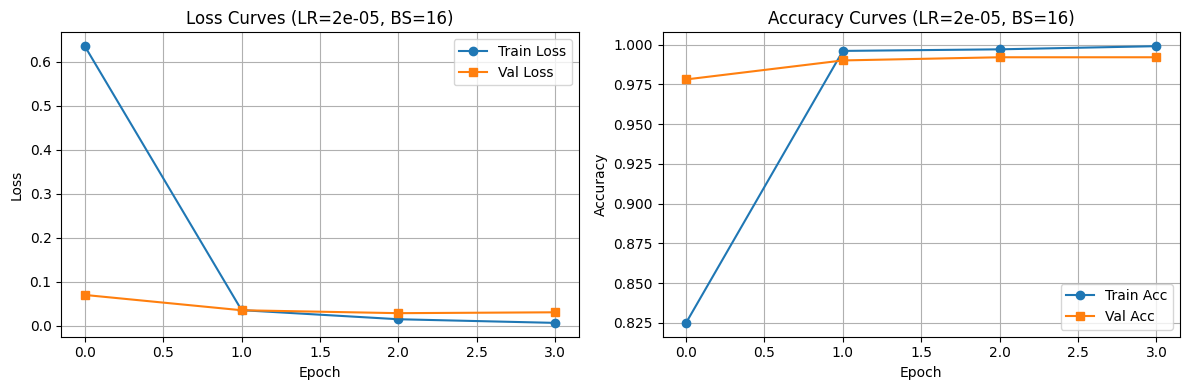


Training with LR=2e-05, BS=32 on cuda
Epoch 1: Train Loss=0.7993, Train Acc=0.7813, Val Loss=0.0948, Val Acc=0.9761
Epoch 2: Train Loss=0.0626, Train Acc=0.9891, Val Loss=0.0398, Val Acc=0.9900
Epoch 3: Train Loss=0.0167, Train Acc=0.9995, Val Loss=0.0227, Val Acc=0.9900
Epoch 4: Train Loss=0.0062, Train Acc=1.0000, Val Loss=0.0237, Val Acc=0.9940
⏹ Early stopping at epoch 4


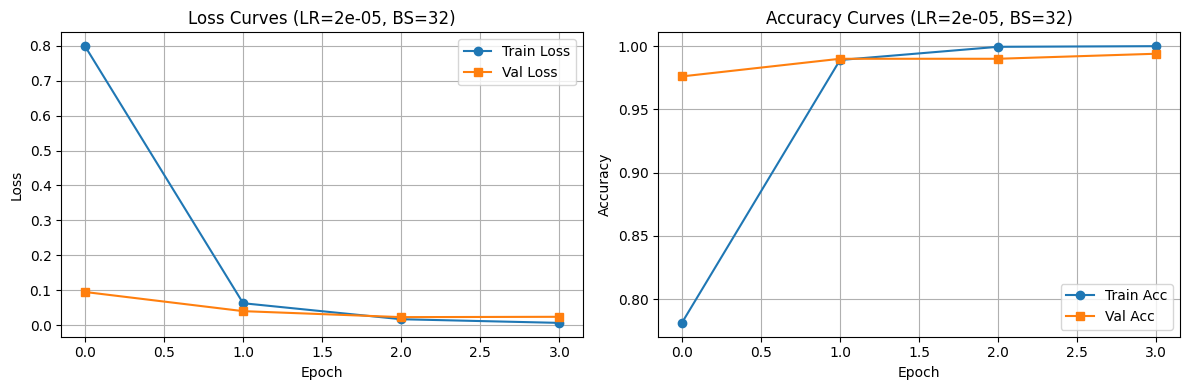


Training with LR=2e-05, BS=64 on cuda
Epoch 1: Train Loss=1.2574, Train Acc=0.6183, Val Loss=0.2919, Val Acc=0.9562
Epoch 2: Train Loss=0.1736, Train Acc=0.9712, Val Loss=0.0604, Val Acc=0.9821
Epoch 3: Train Loss=0.0435, Train Acc=0.9930, Val Loss=0.0424, Val Acc=0.9861
Epoch 4: Train Loss=0.0174, Train Acc=0.9985, Val Loss=0.0316, Val Acc=0.9900
Epoch 5: Train Loss=0.0093, Train Acc=0.9995, Val Loss=0.0286, Val Acc=0.9900


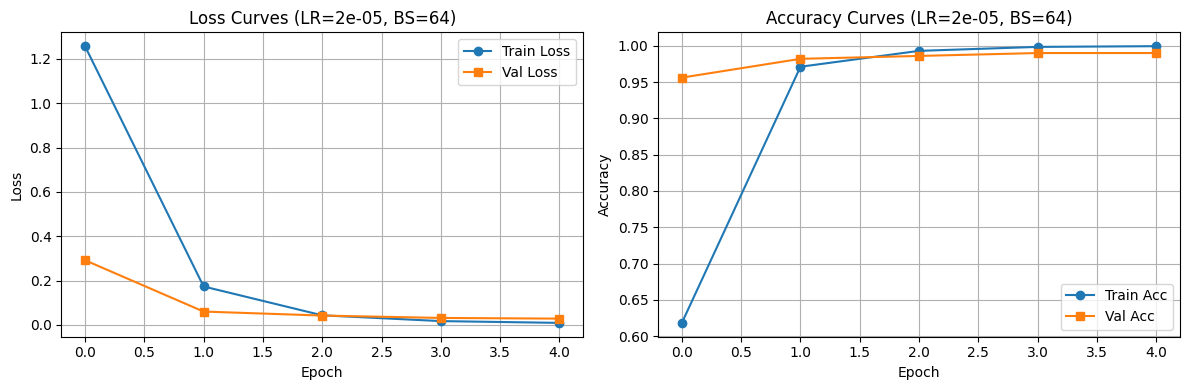


Training with LR=1e-05, BS=16 on cuda
Epoch 1: Train Loss=1.0100, Train Acc=0.7097, Val Loss=0.1482, Val Acc=0.9741
Epoch 2: Train Loss=0.1080, Train Acc=0.9831, Val Loss=0.0446, Val Acc=0.9880
Epoch 3: Train Loss=0.0304, Train Acc=0.9965, Val Loss=0.0423, Val Acc=0.9861
Epoch 4: Train Loss=0.0143, Train Acc=0.9995, Val Loss=0.0211, Val Acc=0.9920
Epoch 5: Train Loss=0.0084, Train Acc=0.9995, Val Loss=0.0236, Val Acc=0.9900
⏹ Early stopping at epoch 5


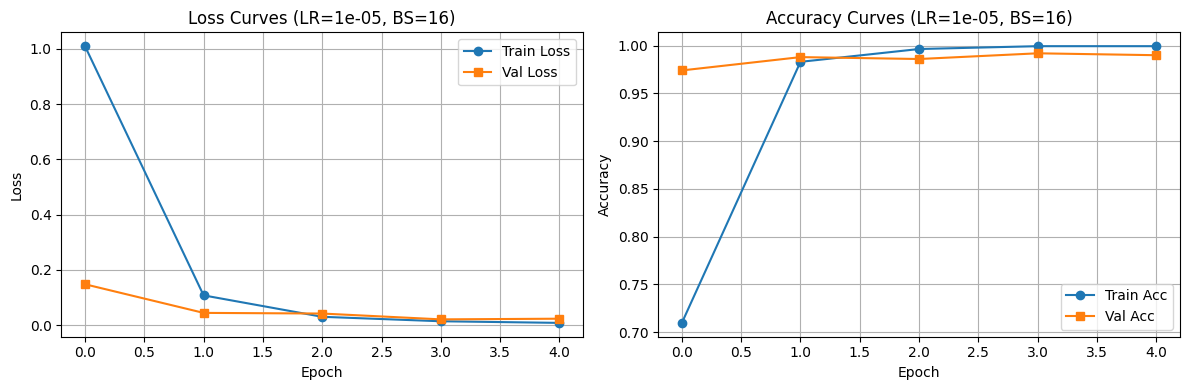


Training with LR=1e-05, BS=32 on cuda
Epoch 1: Train Loss=1.3235, Train Acc=0.6019, Val Loss=0.4094, Val Acc=0.9343
Epoch 2: Train Loss=0.2653, Train Acc=0.9637, Val Loss=0.0879, Val Acc=0.9841
Epoch 3: Train Loss=0.0805, Train Acc=0.9896, Val Loss=0.0454, Val Acc=0.9861
Epoch 4: Train Loss=0.0364, Train Acc=0.9965, Val Loss=0.0337, Val Acc=0.9880
Epoch 5: Train Loss=0.0178, Train Acc=0.9985, Val Loss=0.0285, Val Acc=0.9861


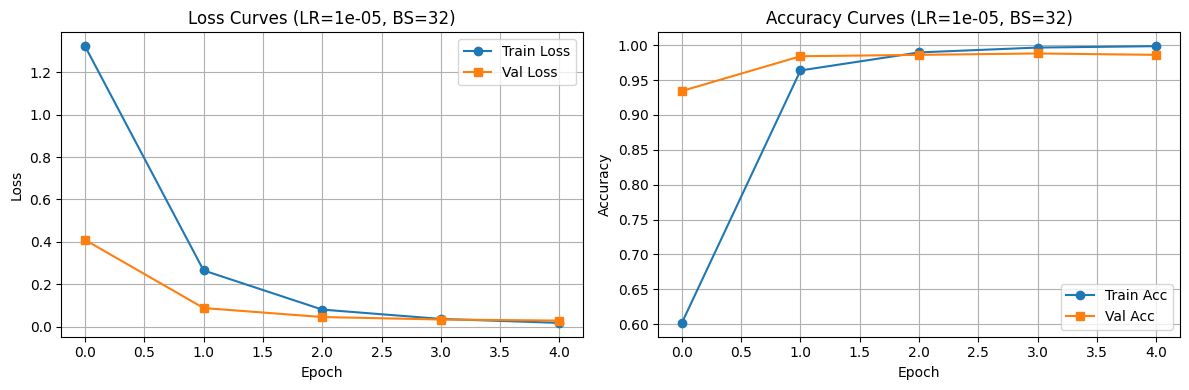


Training with LR=1e-05, BS=64 on cuda
Epoch 1: Train Loss=1.7980, Train Acc=0.4021, Val Loss=0.9599, Val Acc=0.7908
Epoch 2: Train Loss=0.6713, Train Acc=0.8683, Val Loss=0.2264, Val Acc=0.9622
Epoch 3: Train Loss=0.2060, Train Acc=0.9672, Val Loss=0.0855, Val Acc=0.9781
Epoch 4: Train Loss=0.0866, Train Acc=0.9881, Val Loss=0.0511, Val Acc=0.9880
Epoch 5: Train Loss=0.0471, Train Acc=0.9935, Val Loss=0.0407, Val Acc=0.9821


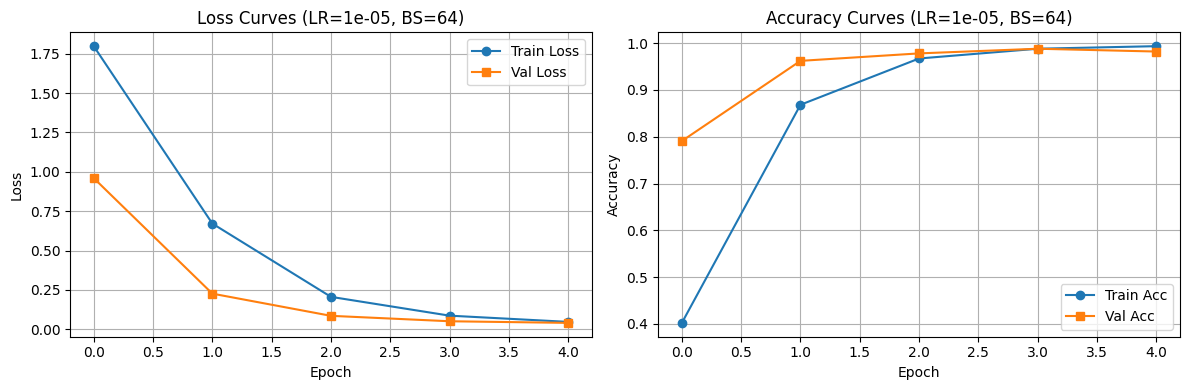

✅ Complete model saved to: saved_models/fold_5_complete_model


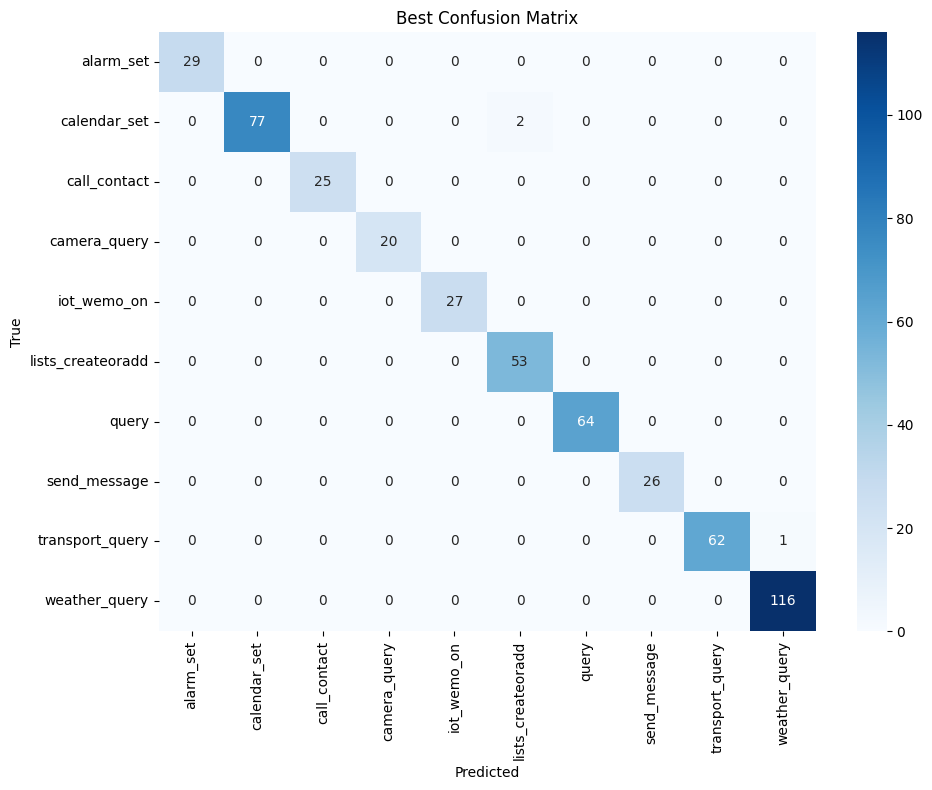

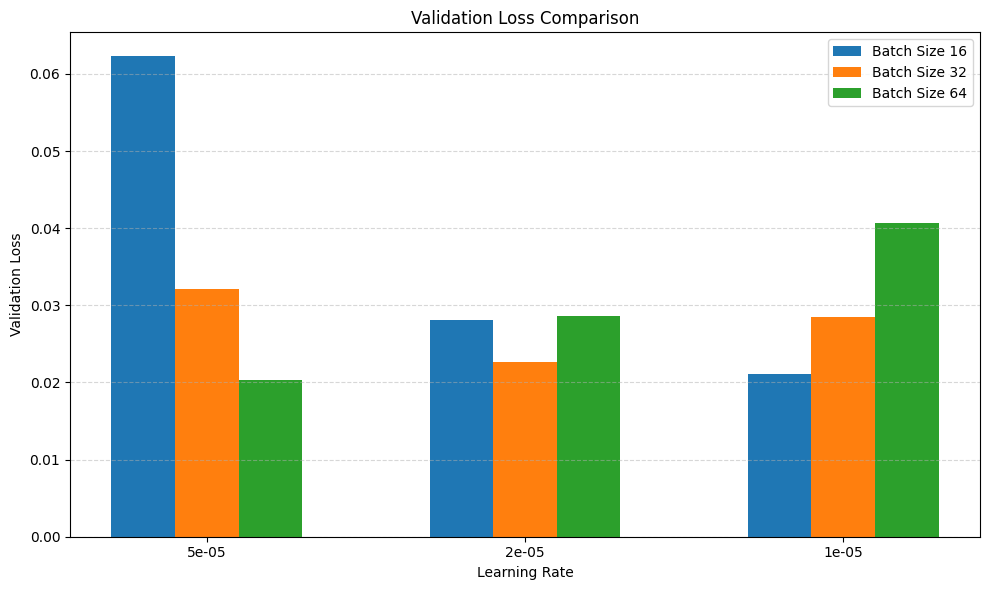


✅ Best Model Saved to: saved_models/fold_5_complete_model
Classification Report:
                    precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        29
     calendar_set       1.00      0.97      0.99        79
     call_contact       1.00      1.00      1.00        25
     camera_query       1.00      1.00      1.00        20
      iot_wemo_on       1.00      1.00      1.00        27
lists_createoradd       0.96      1.00      0.98        53
            query       1.00      1.00      1.00        64
     send_message       1.00      1.00      1.00        26
  transport_query       1.00      0.98      0.99        63
    weather_query       0.99      1.00      1.00       116

         accuracy                           0.99       502
        macro avg       1.00      1.00      1.00       502
     weighted avg       0.99      0.99      0.99       502



Some weights of BertModel were not initialized from the model checkpoint at avichr/heBERT and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully from: saved_models/fold_5_complete_model
📊 Number of classes: 10
🏷️ Intent labels: ['alarm_set', 'calendar_set', 'call_contact', 'camera_query', 'iot_wemo_on', 'lists_createoradd', 'query', 'send_message', 'transport_query', 'weather_query']

📊 Fold 5 Results:
   Accuracy: 0.9940
   Macro F1: 0.9956
   Weighted F1: 0.9940
   Best BS: 64, LR: 5e-05

📊 FINAL CROSS-VALIDATION RESULTS
Best Model: saved_models/fold_2_complete_model, F1=1.0000, BS=32, LR=2e-05
Mean Acc: 0.9940 ± 0.0042
Mean Macro F1: 0.9945 ± 0.0043

📄 Experiment summary saved to: saved_models/experiment_summary.json

🎉 Cross-validation completed successfully!
💾 All models and results saved in 'saved_models/' directory


In [28]:
# COMPLETE CROSS-VALIDATION
results = []
best_f1 = 0.0
best_model_path_overall = ""
best_batch_size_overall = None
best_learning_rate_overall = None

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
fold = 1
os.makedirs("saved_models", exist_ok=True)

for train_idx, val_idx in skf.split(X, y):
    print(f"\n========== Fold {fold} ========== ")
    X_train_texts, X_val_texts = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    encoded_train = tokenizer(list(X_train_texts), padding=True, truncation=True, max_length=128, return_tensors='pt')
    encoded_val = tokenizer(list(X_val_texts), padding=True, truncation=True, max_length=128, return_tensors='pt')

    encoded_inputs_fold = {'input_ids': encoded_train['input_ids'], 'attention_mask': encoded_train['attention_mask']}
    encoded_inputs_val_fold = {'input_ids': encoded_val['input_ids'], 'attention_mask': encoded_val['attention_mask']}

    model_dir = f"saved_models/fold_{fold}_complete_model"
    best_model_path, best_batch_size, best_learning_rate = run_grid_search(
        encoded_inputs_fold, y_train,
        encoded_inputs_val_fold, y_val,
        map_intent, base_model, tokenizer,
        model_save_dir=model_dir
    )

    try:
        eval_model, eval_tokenizer, eval_map_intent = load_complete_model(model_dir)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        eval_model.to(device).eval()

        all_preds, all_labels = [], []
        val_ds = TensorDataset(encoded_inputs_val_fold['input_ids'], encoded_inputs_val_fold['attention_mask'], torch.tensor(y_val))
        val_loader = DataLoader(val_ds, batch_size=best_batch_size, shuffle=False)
        with torch.no_grad():
            for input_ids, attention_mask, labels in val_loader:
                input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
                outputs = eval_model(input_ids, attention_mask)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        macro_f1 = f1_score(all_labels, all_preds, average='macro')
        weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

        sorted_keys = sorted(eval_map_intent.keys(), key=int)
        target_names = [eval_map_intent[k] for k in sorted_keys]
        report = classification_report(all_labels, all_preds, target_names=target_names, output_dict=True)

        print(f"\n📊 Fold {fold} Results:")
        print(f"   Accuracy: {accuracy:.4f}")
        print(f"   Macro F1: {macro_f1:.4f}")
        print(f"   Weighted F1: {weighted_f1:.4f}")
        print(f"   Best BS: {best_batch_size}, LR: {best_learning_rate}")
    except Exception as e:
        print(f"❌ Error evaluating fold {fold}: {e}")
        accuracy = macro_f1 = weighted_f1 = 0.0
        report = {}

    fold_res = {'fold': fold, 'accuracy': accuracy, 'macro_f1': macro_f1, 'weighted_f1': weighted_f1,
                'model_path': model_dir, 'batch_size': best_batch_size, 'learning_rate': best_learning_rate,
                'train_size': len(y_train), 'val_size': len(y_val)}
    if 'macro avg' in report:
        fold_res.update({'precision_macro': report['macro avg']['precision'],
                         'recall_macro': report['macro avg']['recall'],
                         'precision_weighted': report['weighted avg']['precision'],
                         'recall_weighted': report['weighted avg']['recall']})
    results.append(fold_res)

    if macro_f1 > best_f1:
        best_f1 = macro_f1
        best_model_path_overall = model_dir
        best_batch_size_overall = best_batch_size
        best_learning_rate_overall = best_learning_rate
    fold += 1
    if 'eval_model' in locals():
        del eval_model
    torch.cuda.empty_cache()

# Save and summarize results
results_df = pd.DataFrame(results)
results_df.to_csv("saved_models/cross_validation_results.csv", index=False)
print("\n📊 FINAL CROSS-VALIDATION RESULTS\n" + "="*60)
print(f"Best Model: {best_model_path_overall}, F1={best_f1:.4f}, BS={best_batch_size_overall}, LR={best_learning_rate_overall}")
print(f"Mean Acc: {results_df['accuracy'].mean():.4f} ± {results_df['accuracy'].std():.4f}")
print(f"Mean Macro F1: {results_df['macro_f1'].mean():.4f} ± {results_df['macro_f1'].std():.4f}")

# Copy best model
target = "saved_models/best_model_final"
if os.path.exists(target): shutil.rmtree(target)
shutil.copytree(best_model_path_overall, target)
shutil.make_archive("saved_models/best_model_Hebert", 'zip', target)

# Summary JSON
summary_report = {
    "experiment_info": {"total_folds": k, "total_samples": len(X),
                         "num_classes": len(map_intent), "class_names": list(map_intent.values())},
    "best_model": {"path": best_model_path_overall, "macro_f1": float(best_f1),
                    "batch_size": int(best_batch_size_overall) if best_batch_size_overall else None,
                    "learning_rate": float(best_learning_rate_overall) if best_learning_rate_overall else None},
    "performance_stats": {"mean_accuracy": float(results_df['accuracy'].mean()),
                           "std_accuracy": float(results_df['accuracy'].std()),
                           "mean_macro_f1": float(results_df['macro_f1'].mean()),
                           "std_macro_f1": float(results_df['macro_f1'].std()),
                           "mean_weighted_f1": float(results_df['weighted_f1'].mean()),
                           "std_weighted_f1": float(results_df['weighted_f1'].std())}
}
with open("saved_models/experiment_summary.json", "w") as f:
    json.dump(summary_report, f, indent=2)
print("\n📄 Experiment summary saved to: saved_models/experiment_summary.json")
print("\n🎉 Cross-validation completed successfully!")
print("💾 All models and results saved in 'saved_models/' directory")
